# Report DQN project

---



This notebook contains the report of the DQN project as well as the whole code used to produce our results. This project was done in the scope of the course CS-456 : Artificial neural networks/Reinforcement learning. 

Group members : 
- Maradan Théodore 
- Havolli Albias 

The 2 following cells should be run only if using Google Colab. The first cell allow to import the folder project and the second to move to this folder. 

In [1]:
#this first cell allow to import all the files from google drive 
#in this case, we import the folder project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#navigate throw the folder project in order to import all python files
%cd drive/MyDrive/Miniproject_DQN

/content/drive/MyDrive/Miniproject_DQN


Import libraries and environment

In [3]:
#import libraries and environment 

import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

Loading the environment and running it 

['Lausanne', 'Geneva', 'Sion', 'Neuchatel', 'Basel', 'Bern', 'Lucern', 'St-Gallen', 'Zurich']


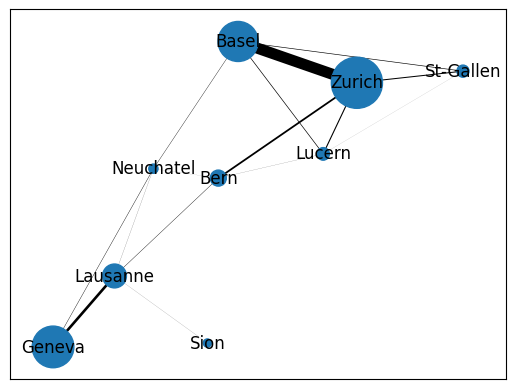

In [4]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
dyn.draw_map()

## 1. Study the behavior of the model when epidemics are unmitigated

---



First of all, we create **actions and observations spaces**

In [ ]:
#create actions and observations space 
action_space        =   spaces.Discrete(5) #from 0 to 4
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

Then, we implement **preprocessing functions for observations and actions** 

In [ ]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

#at each week, redefine again action a false everywhere because only one action can 
#be used per week 
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In the following cell, we **instanciate an environment with set action and observation spaces attributes**.

In [ ]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

This is how to sublass the agent class according to the jupyter notebook tutorial 

In [ ]:
class WithoutMitigationAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # here none action is taken 
        return 0 

Finally, we run the simulation. Don't forget to reset the environment before that. Note that action = 0 means that none actions is undertaken during the whole episode (30 weeks). 

In [ ]:
agent = WithoutMitigationAgent(env)

""" Run the simulation """
log = []
#inf = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

Finally, we can plot our results according to the template given in the tutorial jupyter notebook.

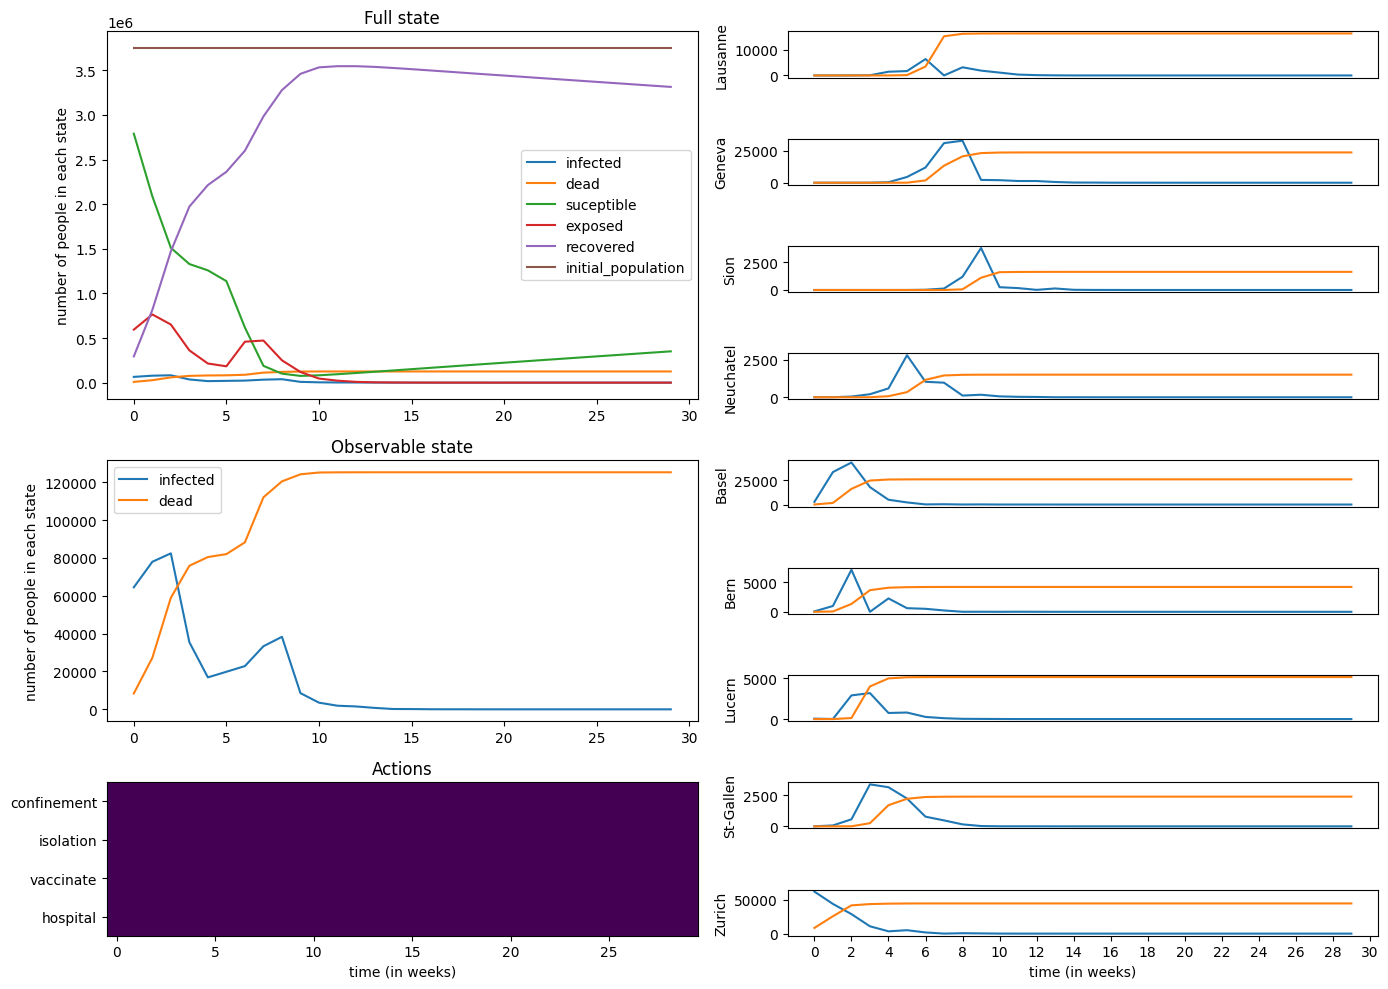

In [ ]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zurich'].set_xlabel('time (in weeks)')
ax_right['Zurich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

## 2. Professor Russo's Policy

---





First of all, we define a new observation_preprocessor function that only count about dead and infected people as this is the only variable of interest in Russo's policy. The action_preprocessor function remains the same as in part 1. Finally, we regroup the nb_infected and the nb_dead variables in an array.

In [ ]:
#compute the total number of infected at the end of each week 
def observation_preprocessor_russo(obs: Observation, dyn:ModelDynamics):
    infected = np.array([np.array(obs.city[c].infected) for c in dyn.cities])
    nb_infected = infected[:,6].sum()
    dead = np.array([np.array(obs.city[c].dead) for c in dyn.cities])
    nb_dead = dead[:,6].sum()
    return np.array([nb_infected, nb_dead])

Here again, we **instanciate an environment with set action and observation spaces attributes**. Compare to the previous part, only the observation_preprocessor function differs. 

In [ ]:
env_russo = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor_russo,
            )

Then, we create an agent that acts according to Russo's policy. 

In [ ]:
class RussoPolicyAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):

        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs, count):
        # this takes an observation and returns an action according to Russo's policy
        if count==0:
          if obs>20000:
            action = 1
            count = count+1
          else:
            action = 0
        elif count>=1 and count<3:
          count = count+1
          action = 1
        elif count==3:
          action = 1
          count = 0
        return action, count


### Q2.a) implement Pr. Russo's policy 
Now, we have everything that we need to run the simulation. 

In [ ]:
agentR = RussoPolicyAgent(env_russo)

""" Run the simulation """
log = []
finished = False
count = 0
obs_russo, info = env_russo.reset(2)
agentR.reset()
#agent.epsilon = 0
while not finished:
    action, count = agentR.act(obs_russo[0], count)
    #print(count)
    obs_russo, R, finished, info = env_russo.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    

""" Parse the logs """
total_russo = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities_russo = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions_russo = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

Finally, we can plot our results. Here again the code below comes from the juptyer notebook tutorial. 

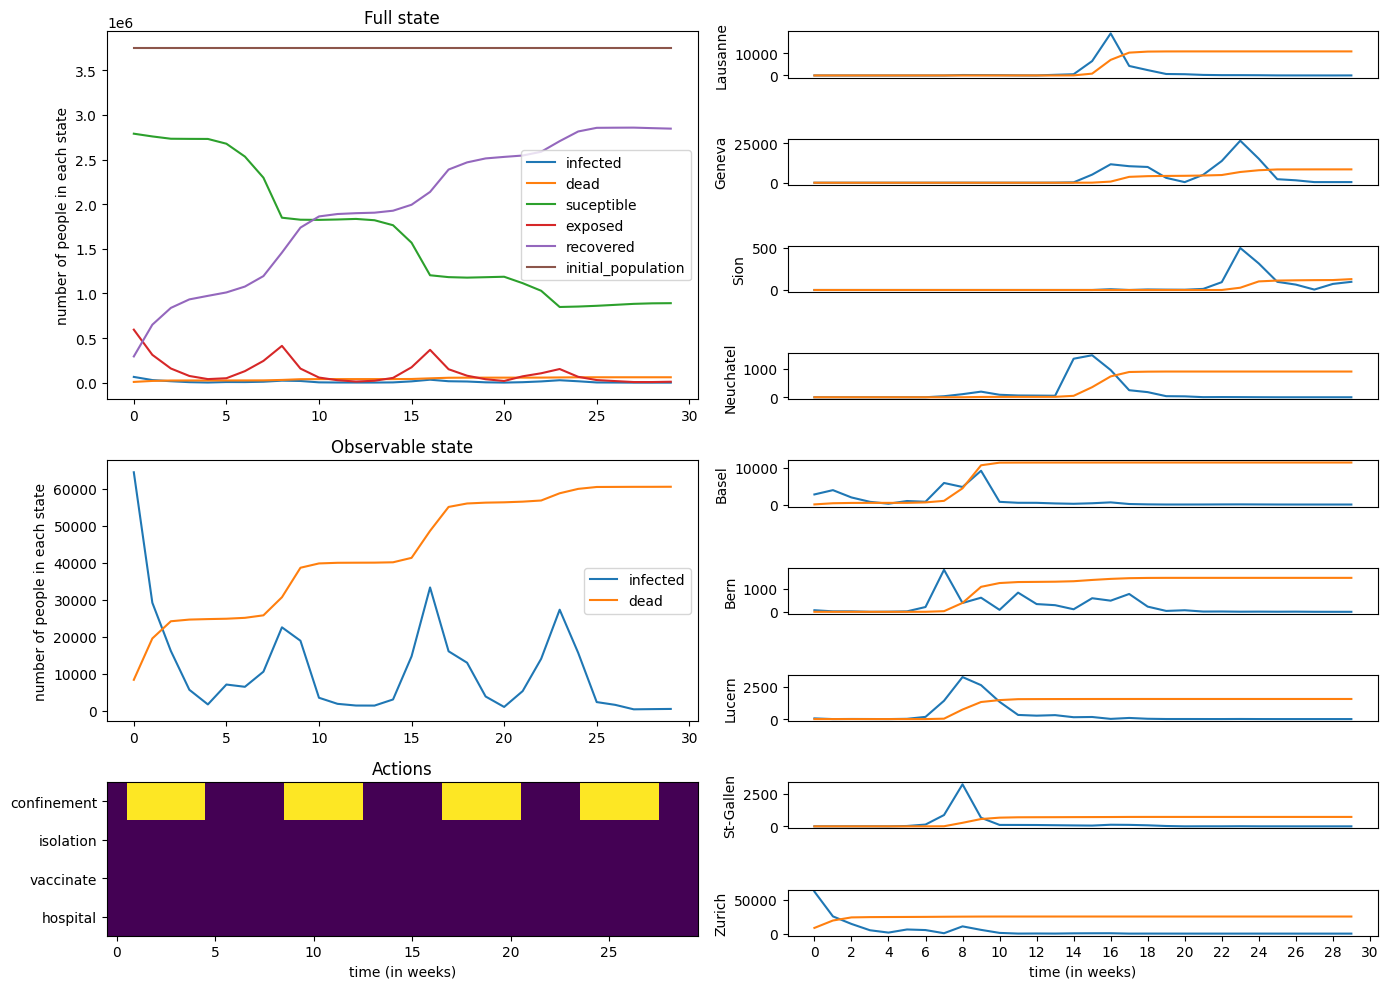

In [ ]:
fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities_russo.keys())}

[ax_leftstate.plot(y) for y in total_russo.values()]
ax_leftstate.legend(total_russo.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total_russo[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions_russo.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions_russo.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities_russo[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities_russo[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zurich'].set_xlabel('time (in weeks)')
ax_right['Zurich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

## Q2.b) Evaluate Pr. Russo's policy

In this part, we are asked to evaluate Pr. Russo's policy by running 50 simulation episodes. For each one of these simulation, we change the seed. To do so, we create a seed array of 50 elements that goes from 1 to 50. 

In [ ]:
nb_episode = 50

#create empty lists that will contain the interested values 
nb_confined_days_per_ep = []
cumulative_reward_per_ep = []
nb_dead_per_ep = []

for i in range(nb_episode):
  """ Run the simulation """
  log = []
  finished = False
  count = 0
  obs_russo, info = env_russo.reset(i+1)
  agentR.reset()
  agentR.epsilon = 0
  Rtot = 0

  while not finished:
     action, count = agentR.act(obs_russo[0], count)
     #action is given to env_russo as a number : 0 or 1
     obs_russo, R, finished, info = env_russo.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         nb_dead_per_ep.append(obs_russo[1])
         cumulative_reward_per_ep.append(Rtot.item())
         confined_week = np.zeros(len(log), np.int64)
         for i in range(len(log)):
           if log[i].action['confinement']==True:
             confined_week[i]=1*7 #nb of confined days = nb of confined week * 7 
         nb_confined_days_per_ep.append(confined_week.sum())
         break


Then, we convert the lists into array so that we can plot the results.

In [ ]:
""" convert list to array """
nb_confined_days_per_ep = np.asarray(nb_confined_days_per_ep)
cumulative_reward_per_ep = np.asarray(cumulative_reward_per_ep)
nb_dead_per_ep = np.asarray(nb_dead_per_ep)

Finally, we can plot our results by using the plotting function from the tutorial jupyter notebook. We brought some modifications to the function so that the plots fit the data. 

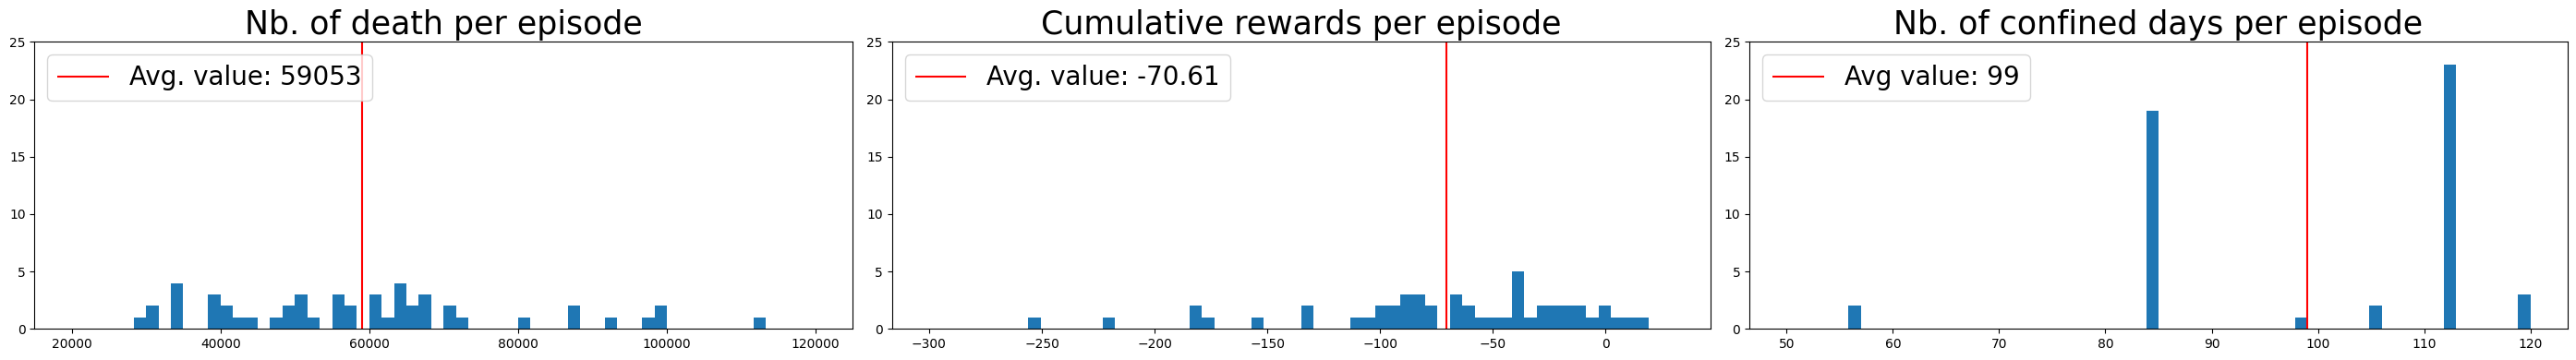

Average death number: 59053.52
Average cumulative reward: -70.61567711353302
Average number of confined days: 98.98


In [ ]:
""" Plotting the results """
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(28,4))
def hist_avg(ax, data,title, labelmean):
    ymax = 25
    if title == 'Nb. of death per episode':
        x_range = (20000,120000)
    elif title == 'Cumulative rewards per episode': 
        x_range = (-300,30)
    elif 'Nb. of confined days per episode' in title:
        x_range = (50,120)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title, fontsize = 25)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red', label = labelmean)
    ax.hist(data,bins=60,range=x_range, linewidth=2)
    ax.legend(loc='upper left', fontsize="20")

    
    
hist_avg(ax1, nb_dead_per_ep,'Nb. of death per episode', 'Avg. value: 59053')
hist_avg(ax2, cumulative_reward_per_ep,'Cumulative rewards per episode', 'Avg. value: -70.61')
hist_avg(ax3, nb_confined_days_per_ep,'Nb. of confined days per episode', 'Avg value: 99')
fig.tight_layout()
plt.show()


""" Print example """
print(f'Average death number: {np.mean(nb_dead_per_ep)}')
print(f'Average cumulative reward: {np.mean(cumulative_reward_per_ep)}')
print(f'Average number of confined days: {np.mean(nb_confined_days_per_ep)}')

## 3) A Deep Q-learning approach

---




Import some useful libraries for Deep Q-Network algorithm 

In [5]:
from collections import namedtuple, deque
from itertools import count
import random 
import copy 
import pickle


import torch.optim as optim
import torch.nn.functional as F

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
if str(device)=='cuda':
    print('nothing to do')
else:
    torch.use_deterministic_algorithms(True)

nothing to do


Initialize hyperparameters and NN's parameters to ensure reproducible training:

In [7]:
NUM_EPISODES = 500
TARGET_UPDATE_RATE = 5 #nb of episodes 
LEARNING_RATE = 5e-3
DISCOUNT_FACTOR = 0.9 #gamma 
BUFFER_SIZE = 20000 
BATCH_SIZE = 2048
EPSILON = 0.7 #exploitation vs exploration
SEED = 2

First of all, let's define the a new observation_preprocessor that will preprocess the observation data into a observation tensor as defined in figure 2 of project's description. 

In [ ]:
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [ ]:
def observation_preprocessor_DQN(obs: Observation, dyn:ModelDynamics):
    infected =  np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead =  np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    infected = infected**0.25
    dead = dead**0.25
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

Let's define now the action_preprocessor function according to the guidlines :

In [ ]:
#In this exercise, the action space is binary : 
action_space_DQN = spaces.Discrete(2)

In [ ]:
ACTION_NONCONFINE = 0
ACTION_CONFINE = 1


def action_preprocessor_DQN(a:torch.Tensor, dyn:ModelDynamics):
    action_DQN = { 
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action_DQN['confinement'] = True
    elif a == ACTION_NONCONFINE:
        action_DQN['confinement'] = False
        
    return action_DQN

In [ ]:
env_DQN = Env(  dyn,
            action_space=action_space_DQN,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_DQN,
            observation_preprocessor=observation_preprocessor_DQN,
            )

Define DQN architecture according to the guidelines 

In [8]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, seed):
        super(DQN, self).__init__()
        #self.seed = torch.cuda.manual_seed(seed)
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, n_actions)

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

Create a replay memory as defined in the pytorch example for DQN :

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Initialize the NNs and differents functions :

In [ ]:
#remind that we have a binary space actions
n_actions = 2
n_observations = 7*9*2

#create two networks that are put to the device for computational efficiency 
policy_net_ini = DQN(n_observations, n_actions, SEED).to(device)
target_net_ini = DQN(n_observations, n_actions, SEED).to(device)

#copy policy_net parameters onto target net ones 
target_net_ini.load_state_dict(policy_net_ini.state_dict())

#optimizer = optim.AdamW(policy_net_ini.parameters(), lr=LEARNING_RATE, amsgrad=True)

#size of memory buffer = 20'000
memory_1 = ReplayMemory(BUFFER_SIZE)
memory_2 = ReplayMemory(BUFFER_SIZE)
memory_3 = ReplayMemory(BUFFER_SIZE)


Create a function that choose action based e-greedy algorithm:

In [9]:
class AgentDQN(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):

        self.env = env
        self.epsilon_max = 0.7
        #self.decay = FALSE 
        self.epsilon_min = 0.2
        self.Tmax = 500
        self.steps = 0
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs, decay, epsilon, time_step, env, fac):
        # this takes an observation and returns an action according to e-greedy algorithm
        sample = random.random()
        #self.steps += 1

        if decay==False:
          if sample>epsilon:
              #exploitation
                with torch.no_grad():
                  # t.max(1) will return the largest column value of each row.
                  # second column on max result is index of where max element was
                  # found, so we pick action with the larger expected reward.
                  #out = policy_net(obs.reshape(1,-1)).max(1)[1].view(1, 1)
                  #print('output', out)
                  if fac==False:
                     return policy_net(obs.reshape(1,-1)).max(1)[1].view(1, 1)
                  else:
                    q_values = policy_net(obs.view(1, -1))
                    return torch.stack([torch.argmax(q_decision, dim=1) for q_decision in q_values], dim=1).view(4)
          else:
              #exploration
              if fac==False:
                 return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
              else:
                 return torch.tensor(env_DQN_fac.action_space.sample(), device=device, dtype=torch.long)
    

        elif decay==True:
          epsilon_t = max(self.epsilon_max*(self.Tmax-(time_step+1))/self.Tmax, self.epsilon_min)
          #print('time step:', time_step)
          #print('epsilon:', epsilon_t)
          if sample>epsilon_t:
            #exploitation
                with torch.no_grad():
                  # t.max(1) will return the largest column value of each row.
                  # second column on max result is index of where max element was
                  # found, so we pick action with the larger expected reward.
                  if fac==False:
                     return policy_net(obs.reshape(1,-1)).max(1)[1].view(1, 1)
                  else:
                    q_values = policy_net(obs.view(1, -1))
                    return torch.stack([torch.argmax(q_decision, dim=1) for q_decision in q_values], dim=1).view(4)             
          else:
              #exploration
              if fac==False:
                return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
              else:
                return torch.tensor(env_DQN_fac.action_space.sample(), device=device, dtype=torch.long)




Implement a function that performs a single optimization step :

In [ ]:
def optimize_model(memory):
    if len(memory) < BATCH_SIZE:
      #print("len memory which is", len(memory),"is smaller than batch size")
      return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values 
    expected_state_action_values = (next_state_values * DISCOUNT_FACTOR) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping (try without this line)
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 50)

    optimizer.step()

### Q3.a) Implementing Deep Q-Learing

Let's now implement our training loop : 

### Training process n°1

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN)
decay = False
best_R = -np.Inf
trace_number = 1
fac = False

policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LEARNING_RATE, amsgrad=True)

memory_1 = ReplayMemory(BUFFER_SIZE)

print(len(memory_1))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN.reset(i+trace_number)
  agentDQN.reset()
  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, 0.7, i, env_DQN, fac)
    obs_DQN, R, finished, _ = env_DQN.step(action)
    Rtot = Rtot+R

  

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_1.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_1)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN, fac)
        obs_DQN, R, finished, info = env_DQN.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      ep = random.randint(0, 19)
      best_log = log[ep]
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)


In [ ]:
eval_trace_1 = eval_trace
training_trace_1 = training_trace 
best_R_1 = best_R
best_model_1 = best_model
best_log_1 = best_log  

In [ ]:
input_1 = [eval_trace_1, training_trace_1, best_R_1, best_model_1, best_log_1]

file_name = "DQN_trace_1.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_1, open_file)
open_file.close()

### Training process n°2 :

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN)
decay = False
best_R = -np.Inf
trace_number = 2
fac = False


policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LEARNING_RATE, amsgrad=True)

memory_2 = ReplayMemory(BUFFER_SIZE)

print(len(memory_2))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN.reset(i+trace_number)
  agentDQN.reset()
  
  
  while not finished: 
    action = agentDQN.act(state.to(device), False, 0.7, i, env_DQN, fac)
    obs_DQN, R, finished, _ = env_DQN.step(action)
    Rtot = Rtot+R

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_2.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_2)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN, fac)
        obs_DQN, R, finished, info = env_DQN.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      ep = random.randint(0, 19)
      best_log = log[ep]
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)


0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

Let's save the differents output from the second training process :

In [ ]:
eval_trace_2 = eval_trace
training_trace_2 = training_trace 
best_R_2 = best_R
best_model_2 = best_model
best_log_2 = best_log  

In [ ]:
input_2 = [eval_trace_2, training_trace_2, best_R_2, best_model_2, best_log_2]

file_name = "DQN_trace_2.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_2, open_file)
open_file.close()

### Training process n°3 :

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN)
decay = False
best_R = -np.Inf
trace_number = 3
fac = False


policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LEARNING_RATE, amsgrad=True)

memory_3 = ReplayMemory(BUFFER_SIZE)

print(len(memory_3))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN.reset(i+trace_number)
  agentDQN.reset()
  
  
  while not finished: 
    action = agentDQN.act(state.to(device), False, 0.7, i, env_DQN, fac)
    obs_DQN, R, finished, _ = env_DQN.step(action)
    Rtot = Rtot+R


    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_3.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_3)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN, fac)
        obs_DQN, R, finished, info = env_DQN.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      ep = random.randint(0, 19)
      best_log = log[ep] 
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')


      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)


0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_3 = eval_trace
training_trace_3 = training_trace 
best_R_3 = best_R
best_model_3 = best_model
best_log_3 = best_log   

In [ ]:
input_3 = [eval_trace_3, training_trace_3, best_R_3, best_model_3, best_log_3]

file_name = "DQN_trace_3.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_3, open_file)
open_file.close()

As we have everything we need, we can plot the training trace and the eval trace. But let's first just process the data. 

In [ ]:
eval_trace_1 = torch.tensor(eval_trace_1)
eval_trace_2 = torch.tensor(eval_trace_2)
eval_trace_3 = torch.tensor(eval_trace_3)

In [ ]:
eval_trace = eval_trace_1+eval_trace_2+eval_trace_3
eval_trace = eval_trace/3
print(eval_trace)

tensor([-148.4661,   27.9369,   30.1471,   32.0060,   32.2966,   32.6466,
          33.6592,   34.1672,   35.0689,   35.3785])


Let's first plot the evaluation trace :

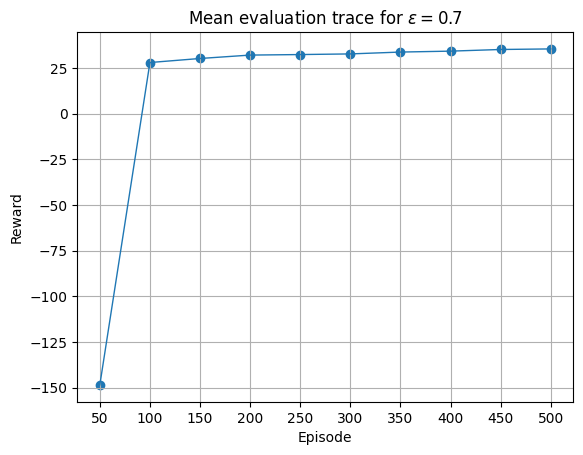

In [ ]:
x = np.linspace(50, 500, 10)

x_space = list(x)
plt.scatter(x, eval_trace)
plt.plot(x,eval_trace, linewidth=1.0)
plt.xticks(x_space)
plt.title("Mean evaluation trace for $\epsilon=0.7$")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

plt.show()


The below cell is only necessary if need to work after time. No need to train agian the NN because we save the results on pkl files. 

In [ ]:
open_file_1 = open("DQN_trace_1.pkl", "rb")
output_1 = pickle.load(open_file_1)
open_file_1.close()

open_file_2 = open("DQN_trace_2.pkl", "rb")
output_2 = pickle.load(open_file_2)
open_file_2.close()

open_file_3 = open("DQN_trace_3.pkl", "rb")
output_3 = pickle.load(open_file_3)
open_file_3.close()

Let's now plot the training trace :

In [ ]:
#training_trace_1 = torch.tensor(output_1[1])
#training_trace_2 = torch.tensor(output_2[1])
#training_trace_3 = torch.tensor(output_3[1])
#or this lines
training_trace_1 = torch.tensor(training_trace_1)
training_trace_2 = torch.tensor(training_trace_2)
training_trace_3 = torch.tensor(training_trace_3)

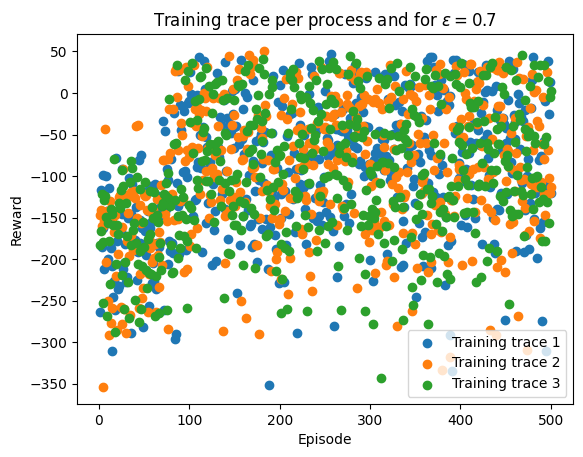

In [ ]:
x_train = np.linspace(1,500,500)

#plotting the results 
plt.scatter(x_train, training_trace_1, label='Training trace 1')
plt.scatter(x_train, training_trace_2, label='Training trace 2')
plt.scatter(x_train, training_trace_3, label='Training trace 3')
plt.title("Training trace per process and for $\epsilon=0.7$")
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.legend(loc='lower right')

plt.show()

We recored three episodes where action are picked by the best policy $\pi_{DQN}^{*}$ and plot one of those episodes. To do so, we first need to load the best model : 

In [ ]:
#run this line to extract the best model parameters and episode recorded from info list if  runtime restarts
best_log = best_log_3

Let's now plot the episode : 

In [ ]:
##Parse the logs 
total_DQN = {p:np.array([getattr(l.total,p) for l in best_log]) for p in dyn.parameters}
cities_DQN = {c:{p:np.array([getattr(l.city[c],p) for l in best_log]) for p in dyn.parameters} for c in dyn.cities}
actions_DQN = {a:np.array([l.action[a] for l in best_log]) for a in best_log[0].action.keys()}

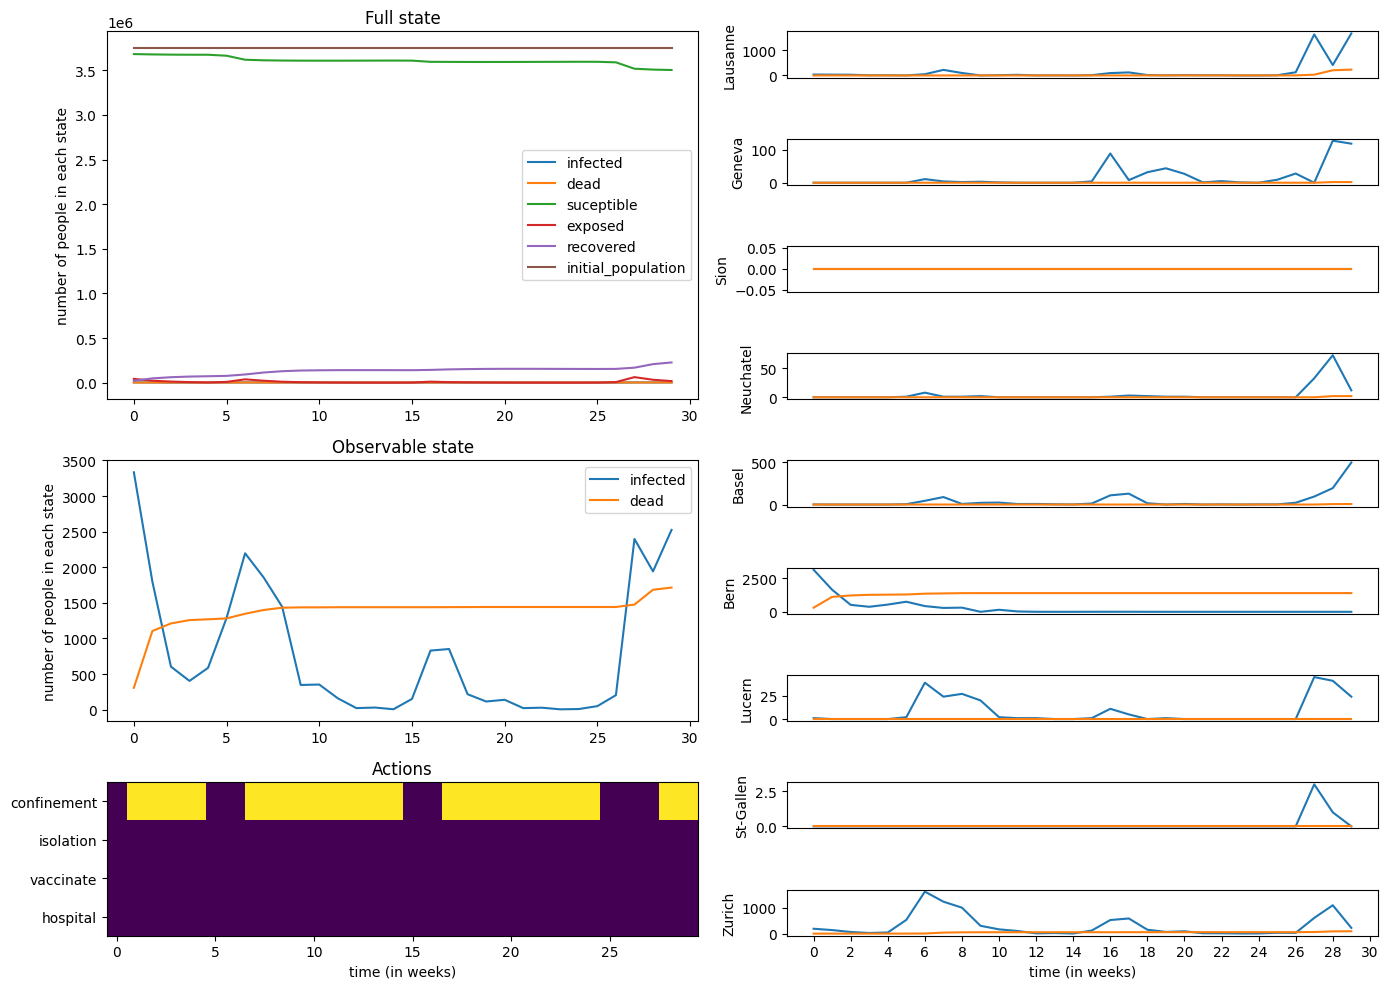

In [ ]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities_DQN.keys())}

[ax_leftstate.plot(y) for y in total_DQN.values()]
ax_leftstate.legend(total_DQN.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total_DQN[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions_DQN.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions_DQN.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities_DQN[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities_DQN[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zurich'].set_xlabel('time (in weeks)')
ax_right['Zurich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

### Q3.b) Decreasing exploration

Let's now proceed the same way as in the previous part but with decreasing exploration (meaning that ϵ decreases over time)

### Training process 1 :

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 1
fac = False

policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LEARNING_RATE, amsgrad=True)

memory_1 = ReplayMemory(BUFFER_SIZE)

print(len(memory_1))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN.reset(i+trace_number)
  agentDQN.reset()
  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, 0.7, i, env_DQN, fac)
    obs_DQN, R, finished, _ = env_DQN.step(action)
    Rtot = Rtot+R


    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_1.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_1)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN, fac)
        obs_DQN, R, finished, info = env_DQN.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      ep = random.randint(0, 19)
      best_log = log[ep]
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)


0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_1_eps = eval_trace
training_trace_1_eps = training_trace 
best_R_1_eps = best_R
best_model_1_eps = best_model
best_log_1_eps = best_log  

In [ ]:
input_1_eps = [eval_trace_1_eps, training_trace_1_eps, best_R_1_eps, best_model_1_eps, best_log_1_eps]

file_name = "DQN_trace_1_eps.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_1_eps, open_file)
open_file.close()

### Training process 2:

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 2
fac = False


policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LEARNING_RATE, amsgrad=True)

memory_2 = ReplayMemory(BUFFER_SIZE)

print(len(memory_2))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN.reset(i+trace_number)
  agentDQN.reset()
  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, 0.7, i, env_DQN, fac)
    obs_DQN, R, finished, _ = env_DQN.step(action)
    Rtot = Rtot+R

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_2.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_2)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN, fac)
        obs_DQN, R, finished, info = env_DQN.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      ep = random.randint(0, 19)
      best_log = log[ep]
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)

0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_2_eps = eval_trace
training_trace_2_eps = training_trace 
best_R_2_eps = best_R
best_model_2_eps = best_model
best_log_2_eps = best_log 

In [ ]:
input_2_eps = [eval_trace_2_eps, training_trace_2_eps, best_R_2_eps, best_model_2_eps, best_log_2_eps]

file_name = "DQN_trace_2_eps.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_2_eps, open_file)
open_file.close()

### Training process 3:

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 3
fac = False


policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LEARNING_RATE, amsgrad=True)

memory_3 = ReplayMemory(BUFFER_SIZE)

print(len(memory_3))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN.reset(i+trace_number)
  agentDQN.reset()
  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, 0.7, i, env_DQN, fac)
    obs_DQN, R, finished, _ = env_DQN.step(action)
    Rtot = Rtot+R


    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_3.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_3)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN, fac)
        obs_DQN, R, finished, info = env_DQN.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      ep = random.randint(0, 19)
      best_log = log[ep]
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)

0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_3_eps = eval_trace
training_trace_3_eps = training_trace 
best_R_3_eps = best_R
best_model_3_eps = best_model
best_log_3_eps = best_log 

In [ ]:
input_3_eps = [eval_trace_3_eps, training_trace_3_eps, best_R_3_eps, best_model_3_eps, best_log_3_eps]

file_name = "DQN_trace_3_eps.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_3_eps, open_file)
open_file.close()

Let's now plot the evaluation trace of  parts 3.a) and 3.b) on a same figure : 

In [ ]:
eval_trace_1_eps = torch.tensor(eval_trace_1_eps)
eval_trace_2_eps = torch.tensor(eval_trace_2_eps)
eval_trace_3_eps = torch.tensor(eval_trace_3_eps)

In [ ]:
eval_trace = eval_trace_1+eval_trace_2+eval_trace_3
eval_trace = eval_trace/3
print(eval_trace)

tensor([-148.4661,   27.9369,   30.1471,   32.0060,   32.2966,   32.6466,
          33.6592,   34.1672,   35.0689,   35.3785])


In [ ]:
eval_trace_eps = eval_trace_1_eps+eval_trace_2_eps+eval_trace_3_eps
eval_trace_eps = eval_trace_eps/3
print(eval_trace_eps)

tensor([-148.4661,   27.9627,   31.4642,   33.6501,   33.6769,   36.2580,
          38.1491,   39.3598,   40.1523,   41.1638])


In [ ]:
T_eps = torch.cat([eval_trace_eps[:0], eval_trace_eps[0+1:]])
print(T_eps)

tensor([27.9627, 31.4642, 33.6501, 33.6769, 36.2580, 38.1491, 39.3598, 40.1523,
        41.1638])


In [ ]:
T = torch.cat([eval_trace[:0], eval_trace[0+1:]])
print(T)

tensor([27.9369, 30.1471, 32.0060, 32.2966, 32.6466, 33.6592, 34.1672, 35.0689,
        35.3785])


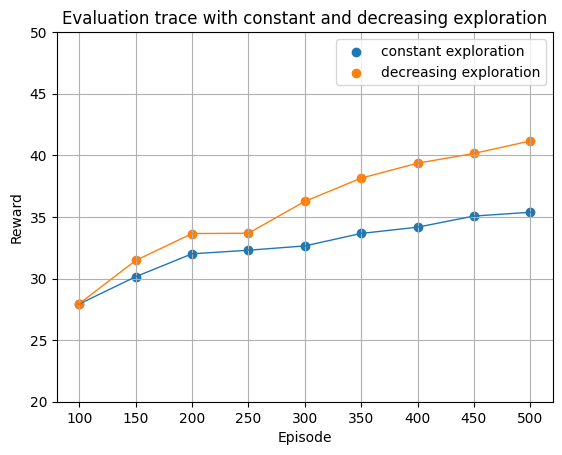

In [ ]:
##plotting code
x = np.linspace(100, 500, 9)

x_space = list(x)
plt.scatter(x, T, label='constant exploration')
plt.scatter(x, T_eps, label='decreasing exploration')
plt.plot(x,T, linewidth=1.0)
plt.plot(x,T_eps, linewidth=1.0)
plt.xticks(x_space)

plt.title("Evaluation trace with constant and decreasing exploration")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.ylim(20, 50)

plt.legend(loc='upper right')
plt.grid(True)

plt.show()

Let's know plot the training trace of parts 3.a) and 3.b) on a same figure too : 

In [ ]:
training_trace_1_eps = torch.tensor(training_trace_1_eps)
training_trace_2_eps = torch.tensor(training_trace_2_eps)
training_trace_3_eps = torch.tensor(training_trace_3_eps)

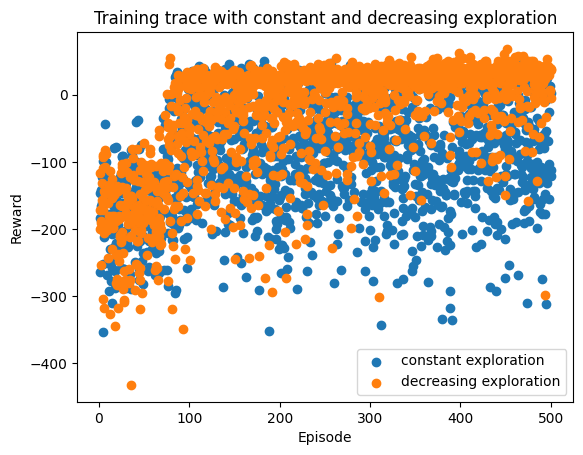

In [ ]:
x_train = np.linspace(1,500,500)

#plotting the results 
plt.scatter(x_train, training_trace_1, color='tab:blue')
plt.scatter(x_train, training_trace_2, color='tab:blue')
plt.scatter(x_train, training_trace_3,color='tab:blue', label='constant exploration')

plt.scatter(x_train, training_trace_1_eps, color='tab:orange')
plt.scatter(x_train, training_trace_2_eps, color='tab:orange')
plt.scatter(x_train, training_trace_3_eps, color='tab:orange', label='decreasing exploration')

plt.title("Training trace with constant and decreasing exploration")
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.legend(loc='lower right')

plt.show()

## Q3.c) Evaluate the best performing policy against Pr. Russo's policy

First determine the best policy $\pi_{DQN}^*$

In [ ]:
#best_model = output_3[3]
best_model = best_model_3_eps
n_observations = 7*9*2
n_actions = 2

In [ ]:
#upload best model parameters to the new NN
best_model_net = DQN(n_observations, n_actions, SEED).to(device)
best_model_net.load_state_dict(best_model)
best_model_net.eval()

DQN(
  (layer1): Linear(in_features=126, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
nb_episode = 50

#create empty lists that will contain the interested values 
nb_confined_days_per_ep = []
cumulative_reward_per_ep = []
nb_dead_per_ep = []

for i in range(nb_episode):
  """ Run the simulation """
  log = []
  finished = False
  count = 0
  obs_DQN, info = env_DQN.reset(i+1)
  #agent_DQN.reset()
  #agent.epsilon = 0
  Rtot = 0

  while not finished:
     state = obs_DQN
     action = best_model_net(state.to(device).reshape(1,-1)).max(1)[1].view(1,1)
     #action is given to env_russo as a number : 0 or 1
     obs_DQN, R, finished, info = env_DQN.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         nb_dead_per_ep.append(log[len(log)-1].total.dead)
         cumulative_reward_per_ep.append(Rtot.item())
         confined_week = np.zeros(len(log), np.int64)
         for i in range(len(log)):
           if log[i].action['confinement']==True:
             confined_week[i]=1*7 #nb of confined days = nb of confined week * 7 
         nb_confined_days_per_ep.append(confined_week.sum())
         break


In [ ]:
""" convert list to array """
nb_confined_days_per_ep = np.asarray(nb_confined_days_per_ep)
cumulative_reward_per_ep = np.asarray(cumulative_reward_per_ep)
nb_dead_per_ep = np.asarray(nb_dead_per_ep)

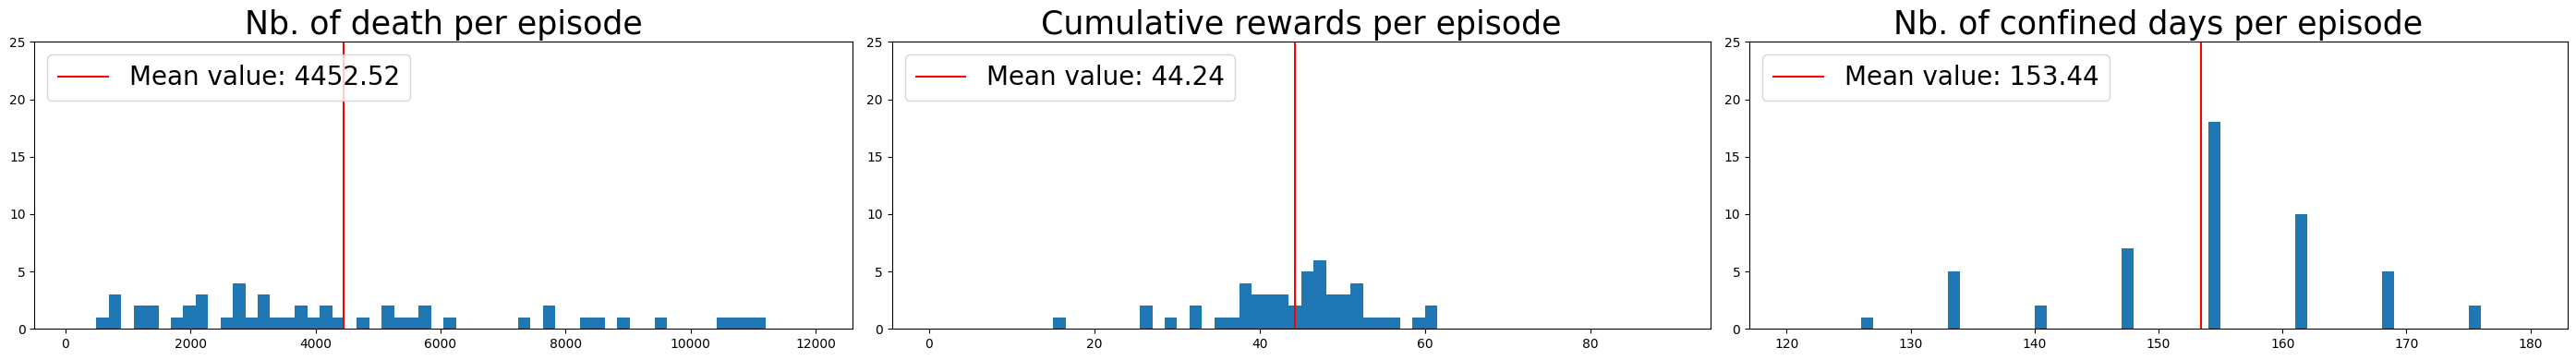

Average death number: 4452.52
Average cumulative reward: 44.24393472671509
Average number of confined days: 153.44


In [ ]:
""" Plotting the results """
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(28,4))
def hist_avg(ax, data,title, labelmean):
    ymax = 25
    if title == 'Nb. of death per episode':
        x_range = (100,12000)
    elif title == 'Cumulative rewards per episode': 
        x_range = (0,90)
    elif 'Nb. of confined days per episode' in title:
        x_range = (120,180)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title, fontsize=25)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red', label=labelmean)
    ax.hist(data,bins=60,range=x_range)
    ax.legend(loc='upper left', fontsize="20")
    
hist_avg(ax1, nb_dead_per_ep,'Nb. of death per episode', 'Mean value: {:.2f}'.format(np.mean(nb_dead_per_ep)))
hist_avg(ax2, cumulative_reward_per_ep,'Cumulative rewards per episode', 'Mean value: {:.2f}'.format(np.mean(cumulative_reward_per_ep)))
hist_avg(ax3, nb_confined_days_per_ep,'Nb. of confined days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_confined_days_per_ep)))
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(nb_dead_per_ep)}')
print(f'Average cumulative reward: {np.mean(cumulative_reward_per_ep)}')
print(f'Average number of confined days: {np.mean(nb_confined_days_per_ep)}')

## 4) Dealing with a more complex action space

### 4.1.b) Toggle-action-space multi-action policy training

Let's fire rewrite the preprocessor action and observation functions according to the guidelines 

In [15]:
action_space_DQN_toggle = spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [16]:
ACTION_NULL = 0
ACTION_TOGGLE_CONFINE = 1
ACTION_TOGGLE_ISOLATE = 2
ACTION_TOGGLE_HOSPITAL = 3
ACTION_TOGGLE_VACCINATE = 4

def action_preprocessor_DQN_toggle(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action().copy()
    if a == 1:
        action['confinement'] = not action['confinement']
    elif a == 2:
        action['isolation'] = not action['isolation']
    elif a == 3:
        action['hospital'] = not action['hospital']
    elif a == 4:
        action['vaccinate'] = not action['vaccinate']
        
    return action
    
def observation_preprocessor_DQN_toggle(obs: Observation, dyn:ModelDynamics):
    infected =  np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead =  np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    infected = infected**0.25
    dead = dead**0.25 

    obs = np.stack((infected, dead)).reshape(126,-1)
    state = torch.Tensor(list(dyn.get_action().values())).reshape(4,-1)

    return torch.Tensor(np.concatenate([obs, state])).unsqueeze(0)

Initialize the environment:

In [17]:
env_DQN_toggle = Env(  dyn,
            action_space=action_space_DQN_toggle,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_DQN_toggle,
            observation_preprocessor=observation_preprocessor_DQN_toggle,
            )

Initialize NN parameters and replay memories:

In [18]:
#remind that we have a binary space actions
n_actions = 5
n_observations = 7*9*2+4

#create two networks that are put to the device for computational efficiency 
policy_net_ini = DQN(n_observations, n_actions, SEED).to(device)
target_net_ini = DQN(n_observations, n_actions, SEED).to(device)

#copy policy_net parameters onto target net ones 
target_net_ini.load_state_dict(policy_net_ini.state_dict())

lr_toggle = 1e-1


### Training process 1 :

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN_toggle)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 1
fac = False

policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr_toggle, amsgrad=True)

memory_1_tog = ReplayMemory(BUFFER_SIZE)

print(len(memory_1_tog))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN_toggle.reset(i+trace_number)
  agentDQN.reset()
  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, None, i, env_DQN_toggle, fac)
    obs_DQN, R, finished, _ = env_DQN_toggle.step(action)
    Rtot = Rtot+R

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_1_tog.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_1_tog)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN_toggle.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN_toggle, fac)
        obs_DQN, R, finished, info = env_DQN_toggle.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      best_log = log
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')

      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)

0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_1_tog = eval_trace
training_trace_1_tog = training_trace 
best_R_1_tog = best_R
best_model_1_tog = best_model
best_log_1_tog = best_log  

In [ ]:
input_1_tog = [eval_trace_1_tog, training_trace_1_tog, best_R_1_tog, best_model_1_tog, best_log_1_tog]

file_name = "DQN_trace_1_tog.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_1_tog, open_file)
open_file.close()

### Training process n°2:

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN_toggle)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 2
fac = False

policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr_toggle, amsgrad=True)

memory_2_tog = ReplayMemory(BUFFER_SIZE)

print(len(memory_2_tog))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN_toggle.reset(i+trace_number)
  agentDQN.reset()

  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, None, i, env_DQN_toggle, fac)
    obs_DQN, R, finished, _ = env_DQN_toggle.step(action)
    Rtot = Rtot+R

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_2_tog.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_2_tog)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN_toggle.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN_toggle, fac)
        obs_DQN, R, finished, info = env_DQN_toggle.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      best_log = log
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')

      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)

0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_2_tog = eval_trace
training_trace_2_tog = training_trace 
best_R_2_tog = best_R
best_model_2_tog = best_model
best_log_2_tog = best_log  

In [ ]:
input_2_tog = [eval_trace_2_tog, training_trace_2_tog, best_R_2_tog, best_model_2_tog, best_log_2_tog]

file_name = "DQN_trace_2_tog.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_2_tog, open_file)
open_file.close()

### Training process n°3:

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN_toggle)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 3
fac = False


policy_net = DQN(n_observations, n_actions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = DQN(n_observations, n_actions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr_toggle, amsgrad=True)

memory_3_tog = ReplayMemory(BUFFER_SIZE)

print(len(memory_3_tog))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN_toggle.reset(i+trace_number)
  agentDQN.reset()

  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, None, i, env_DQN_toggle, fac)
    obs_DQN, R, finished, _ = env_DQN_toggle.step(action)
    Rtot = Rtot+R

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_3_tog.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model(memory_3_tog)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN_toggle.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN_toggle, fac)
        obs_DQN, R, finished, info = env_DQN_toggle.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      best_log = log
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)

0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_3_tog = eval_trace
training_trace_3_tog = training_trace 
best_R_3_tog = best_R
best_model_3_tog = best_model
best_log_3_tog = best_log  

In [ ]:
input_3_tog = [eval_trace_3_tog, training_trace_3_tog, best_R_3_tog, best_model_3_tog, best_log_3_tog]

file_name = "DQN_trace_3_tog.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_3_tog, open_file)
open_file.close()

Let's now compute the training and evaluation traces: 

In [ ]:
training_trace_1_tog = torch.tensor(training_trace_1_tog)
training_trace_2_tog = torch.tensor(training_trace_2_tog)
training_trace_3_tog = torch.tensor(training_trace_3_tog)

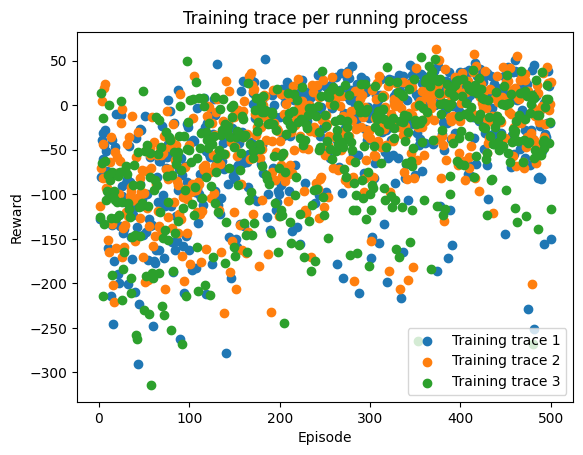

In [ ]:
x_train = np.linspace(1,500,500)

#plotting the results 
plt.scatter(x_train, training_trace_1_tog, label='Training trace 1')
plt.scatter(x_train, training_trace_2_tog, label='Training trace 2')
plt.scatter(x_train, training_trace_3_tog, label='Training trace 3')
plt.title("Training trace per running process")
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.legend(loc='lower right')

plt.show()

In [ ]:
eval_trace_1_tog = torch.tensor(eval_trace_1_tog)
eval_trace_2_tog = torch.tensor(eval_trace_2_tog)   
eval_trace_3_tog = torch.tensor(eval_trace_3_tog)

In [ ]:
eval_trace_tog = eval_trace_1_tog+eval_trace_2_tog+eval_trace_3_tog
eval_trace_tog = eval_trace_tog/3
print(eval_trace_tog)

tensor([-136.2715,  -45.5968,  -11.8819,  -11.4469,  -17.7001,    7.4321,
           6.8547,   -2.2888,    1.7399,    7.4135])


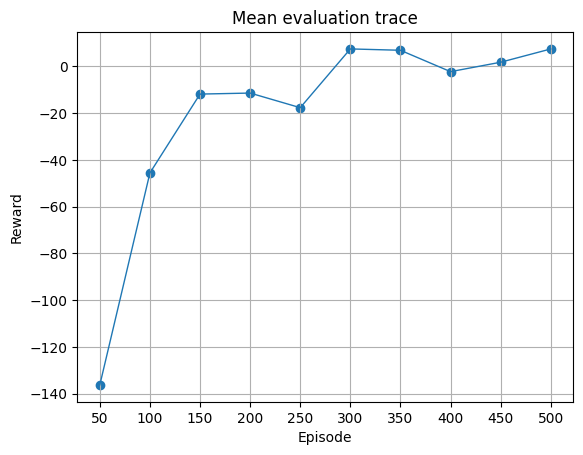

In [ ]:
x = np.linspace(50, 500, 10)

x_space = list(x)
plt.scatter(x, eval_trace_tog)
plt.plot(x,eval_trace_tog, linewidth=1.0)
plt.xticks(x_space)
plt.title("Mean evaluation trace")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

plt.show()

Let's run 3 episodes of the best policy $\pi_{toggle}^*$ and plot one of them :

In [10]:
open_file_1_tog = open("DQN_trace_1_tog.pkl", "rb")
output_1_tog = pickle.load(open_file_1_tog)
open_file_1_tog.close()

open_file_2_tog = open("DQN_trace_2_tog.pkl", "rb")
output_2_tog = pickle.load(open_file_2_tog)
open_file_2_tog.close()

open_file_3_tog = open("DQN_trace_3_tog.pkl", "rb")
output_3_tog = pickle.load(open_file_3_tog)
open_file_3_tog.close()

In [11]:
best_model_1_tog = output_1_tog[3]

In [12]:
n_actions = 5
n_observations = 7*9*2+4

In [13]:
best_model_net = DQN(n_observations, n_actions, SEED).to(device)
best_model_net.load_state_dict(best_model_1_tog)
best_model_net.eval()

DQN(
  (layer1): Linear(in_features=130, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=5, bias=True)
)

In [19]:
finished = False
Rtot_eval = 0
agentDQN = AgentDQN(env_DQN_toggle)
obs_DQN, info = env_DQN_toggle.reset(4)
agentDQN.reset()
log_j = []
      
      
while not finished:
  state = obs_DQN
  action = best_model_net(state.reshape(1,-1).to(device)).max(1)[1].view(1, 1)
  obs_DQN, R, finished, info = env_DQN_toggle.step(action)
  log_j.append(info)  # save the information dict for logging
  Rtot_eval = Rtot_eval+R
  if finished:
    print('total reward:', Rtot_eval)

total reward: tensor([[53.2789]])


In [20]:
total_DQN = {p:np.array([getattr(l.total,p) for l in log_j]) for p in dyn.parameters}
cities_DQN = {c:{p:np.array([getattr(l.city[c],p) for l in log_j]) for p in dyn.parameters} for c in dyn.cities}
actions_DQN = {a:np.array([l.action[a] for l in log_j]) for a in log_j[0].action.keys()}

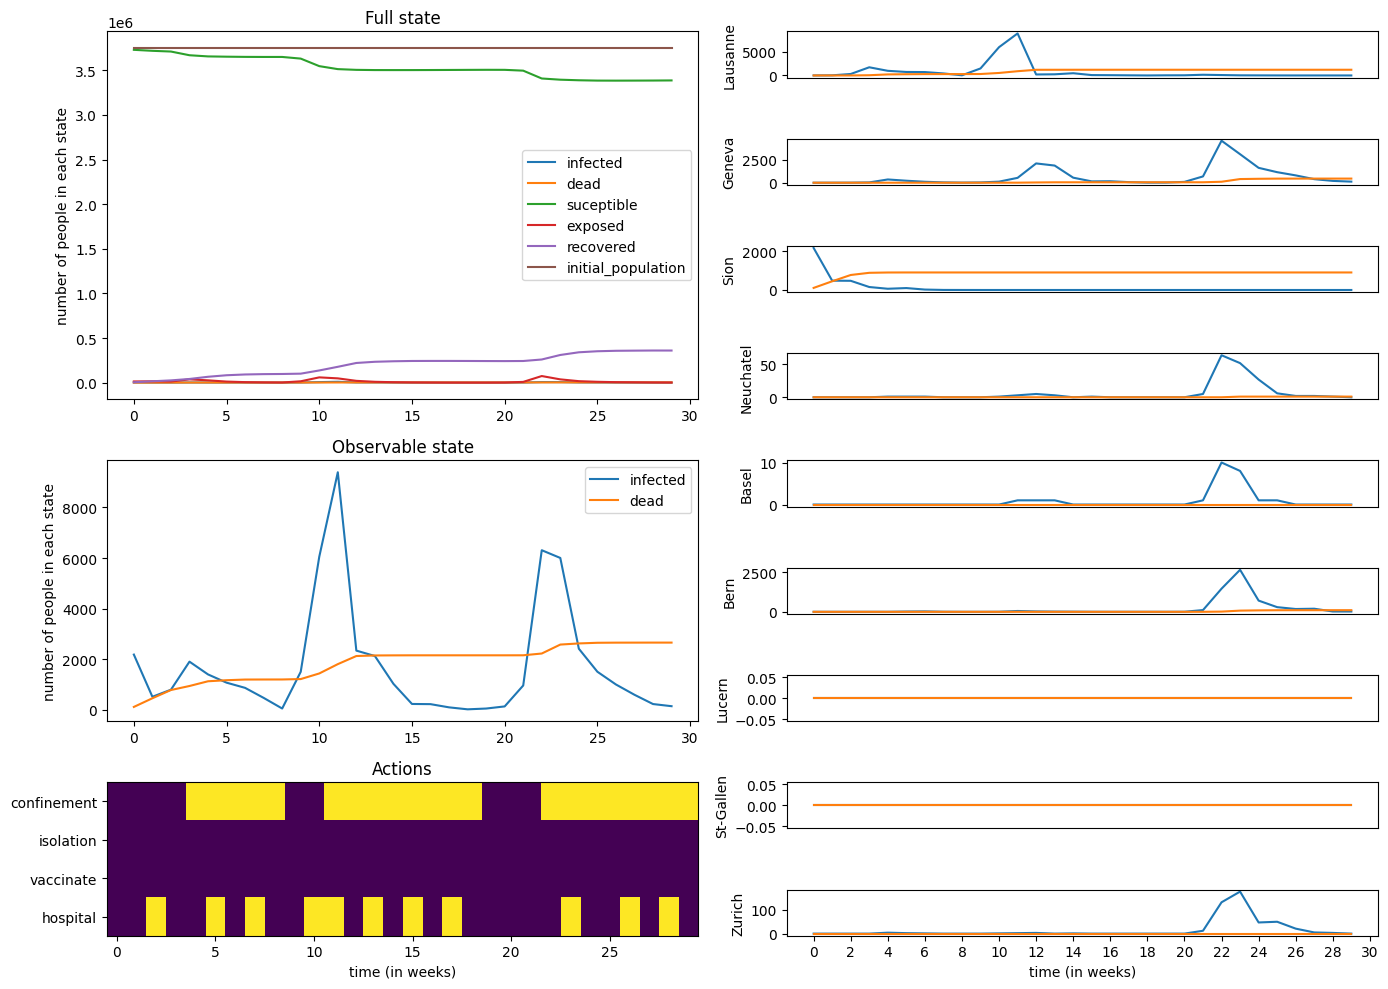

In [21]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities_DQN.keys())}

[ax_leftstate.plot(y) for y in total_DQN.values()]
ax_leftstate.legend(total_DQN.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total_DQN[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions_DQN.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions_DQN.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities_DQN[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities_DQN[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zurich'].set_xlabel('time (in weeks)')
ax_right['Zurich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

## 4.1.c) Toggle-action-space multi-action policy evaluation

In [ ]:
nb_episode = 50

#create empty lists that will contain the interested values 
nb_confined_days_per_ep = []
nb_vaccinate_days_per_ep = []
nb_isolation_days_per_ep = []
nb_hospital_days_per_ep = []
cumulative_reward_per_ep = []
nb_dead_per_ep = []


log_action = []

for i in range(nb_episode):
  """ Run the simulation """
  log = []
  finished = False
  obs_DQN, info = env_DQN_toggle.reset(i+1)
  #agent_DQN.reset()
  #agent.epsilon = 0
  Rtot = 0

  while not finished:
     state = obs_DQN
     action = best_model_net(state.to(device).reshape(1,-1)).max(1)[1].view(1,1)
     obs_DQN, R, finished, info = env_DQN_toggle.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         
         nb_dead_per_ep.append(log[len(log)-1].total.dead)
         cumulative_reward_per_ep.append(Rtot.item())
         confined_week = np.zeros(len(log), np.int64)
         vaccinate_week = np.zeros(len(log), np.int64)
         isolation_week = np.zeros(len(log), np.int64)
         hospital_week = np.zeros(len(log), np.int64)
         for i in range(len(log)):
           # print('nb week',i,'with the following action:', log[i].action)
           if log[i].action['confinement']==True:
             confined_week[i] = 1*7 #nb of confined days = nb of confined week * 7 
           if log[i].action['isolation']==True:
             isolation_week[i] = 1*7
           if log[i].action['vaccinate']==True:
             vaccinate_week[i] = 1*7
           if log[i].action['hospital']==True:
             hospital_week[i] = 1*7
         nb_confined_days_per_ep.append(confined_week.sum())
         nb_vaccinate_days_per_ep.append(vaccinate_week.sum())
         nb_isolation_days_per_ep.append(isolation_week.sum())
         nb_hospital_days_per_ep.append(hospital_week.sum())
         break

In [ ]:
""" convert list to array """
nb_confined_days_per_ep = np.asarray(nb_confined_days_per_ep)
nb_hospital_days_per_ep = np.asarray(nb_hospital_days_per_ep)
nb_vaccinate_days_per_ep = np.asarray(nb_vaccinate_days_per_ep)
nb_isolation_days_per_ep = np.asarray(nb_isolation_days_per_ep)
cumulative_reward_per_ep = np.asarray(cumulative_reward_per_ep)
nb_dead_per_ep = np.asarray(nb_dead_per_ep)

In [ ]:
print(np.min(nb_confined_days_per_ep), np.max(nb_confined_days_per_ep))
print(np.min(nb_hospital_days_per_ep), np.max(nb_hospital_days_per_ep))
print(np.min(nb_vaccinate_days_per_ep), np.max(nb_vaccinate_days_per_ep))
print(np.min(nb_isolation_days_per_ep), np.max(nb_isolation_days_per_ep))
print(np.min(cumulative_reward_per_ep), np.max(cumulative_reward_per_ep))
print(np.min(nb_dead_per_ep), np.max(nb_dead_per_ep))

133 175
63 133
0 0
0 182
-110.47450256347656 53.27885818481445
394 53837


In [ ]:
print(np.mean(nb_confined_days_per_ep))
print(np.mean(nb_hospital_days_per_ep))
print(np.mean(nb_vaccinate_days_per_ep))
print(np.mean(nb_isolation_days_per_ep))
print(np.mean(cumulative_reward_per_ep))
print(np.mean(nb_dead_per_ep))

154.42
93.1
0.0
12.6
11.666684077978134
11689.3


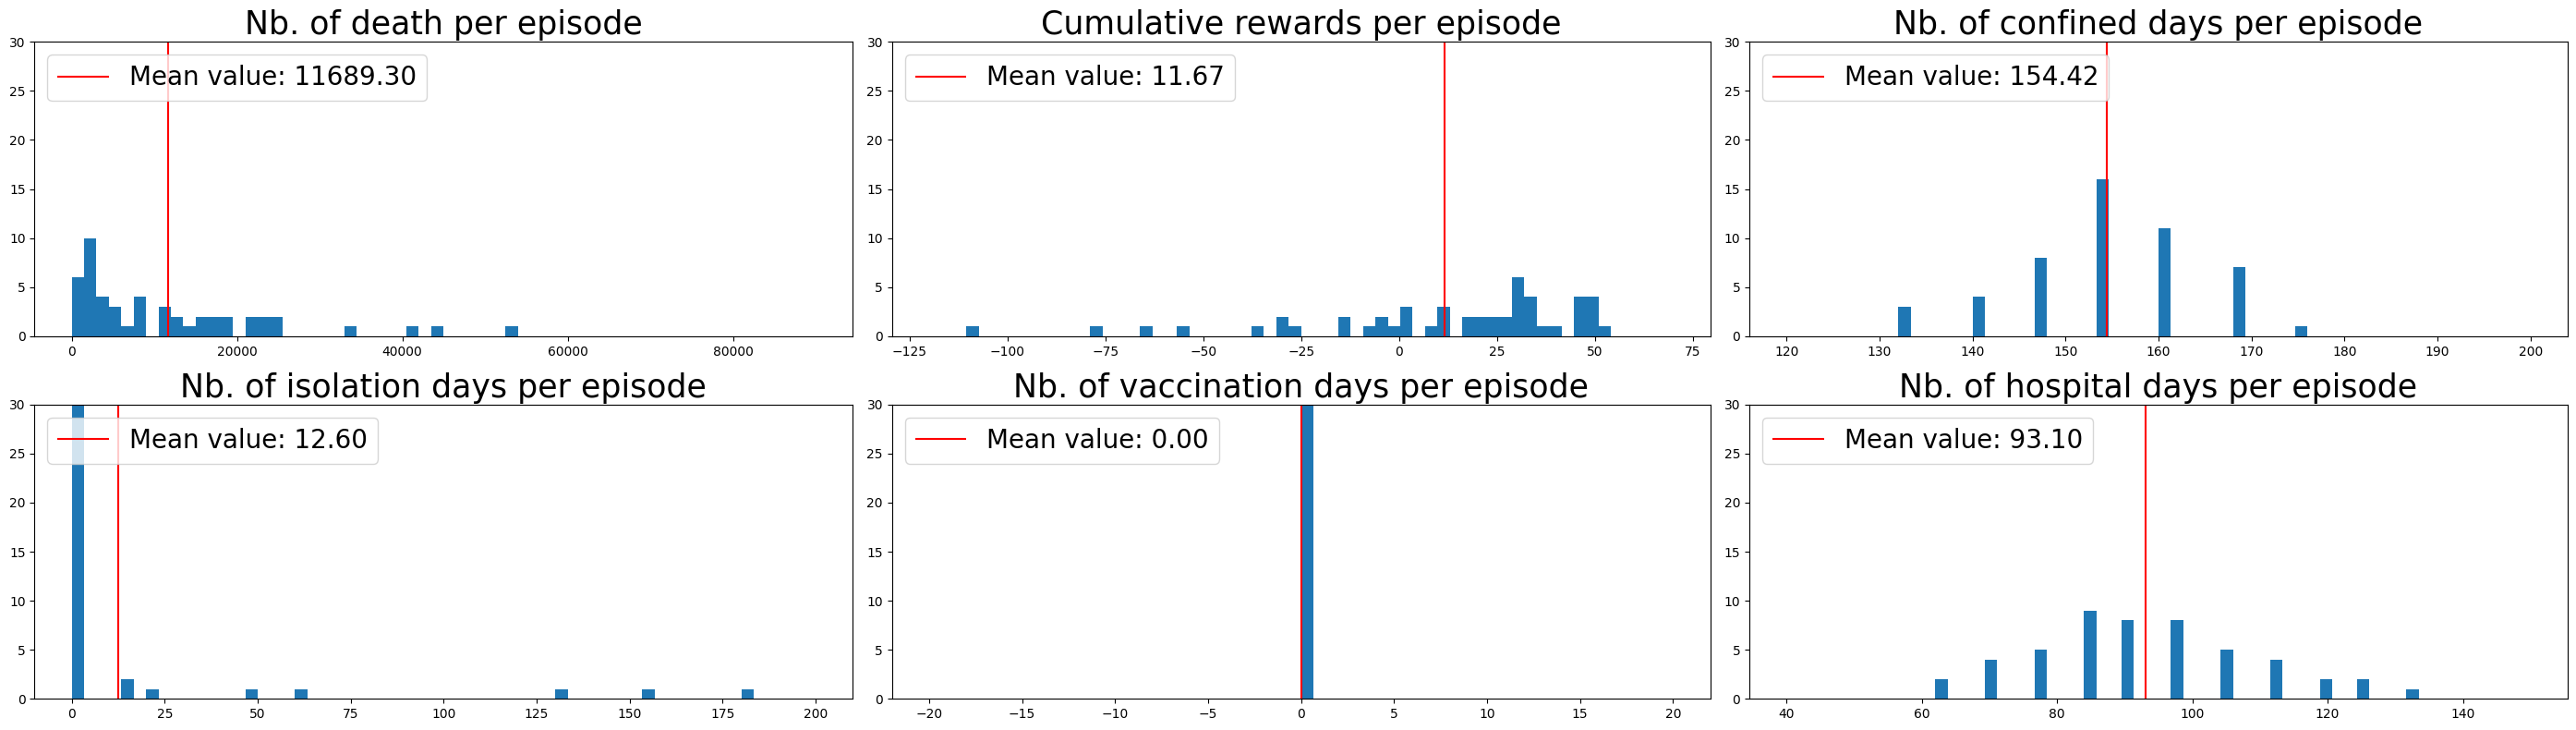

Average death number: 11689.3
Average cumulative reward: 11.666684077978134
Average number of confined days: 154.42
Average number of isolation days:12.6
Average number of vaccinate days:0.0
Average number of hospital days:93.1


In [ ]:
""" Plotting the results """
fig, ax = plt.subplots(2,3,figsize=(28,8))
def hist_avg(ax, data,title, labelmean):
    ymax = 30
    if title == 'Nb. of death per episode':
        x_range = (0,90000)
    elif title == 'Cumulative rewards per episode': 
        x_range = (-120,70)
    elif 'Nb. of confined days per episode' in title:
        x_range = (120,200)
    elif title == 'Nb. of isolation days per episode':
        x_range = (0, 200)
    elif title == 'Nb. of vaccination days per episode':
        x_range = (-20, 20)
    elif title == 'Nb. of hospital days per episode':
        x_range = (40, 150)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title, fontsize=25)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red', label=labelmean)
    ax.hist(data,bins=60,range=x_range)
    ax.legend(loc='upper left', fontsize="20")
    
hist_avg(ax[0,0], nb_dead_per_ep,'Nb. of death per episode', 'Mean value: {:.2f}'.format(np.mean(nb_dead_per_ep)))
hist_avg(ax[0,1], cumulative_reward_per_ep,'Cumulative rewards per episode', 'Mean value: {:.2f}'.format(np.mean(cumulative_reward_per_ep)))
hist_avg(ax[0,2], nb_confined_days_per_ep,'Nb. of confined days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_confined_days_per_ep)))
hist_avg(ax[1,0], nb_isolation_days_per_ep,'Nb. of isolation days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_isolation_days_per_ep)))
hist_avg(ax[1,1], nb_vaccinate_days_per_ep,'Nb. of vaccination days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_vaccinate_days_per_ep)))
hist_avg(ax[1,2], nb_hospital_days_per_ep,'Nb. of hospital days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_hospital_days_per_ep)))
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(nb_dead_per_ep)}')
print(f'Average cumulative reward: {np.mean(cumulative_reward_per_ep)}')
print(f'Average number of confined days: {np.mean(nb_confined_days_per_ep)}')
print(f'Average number of isolation days:{np.mean(nb_isolation_days_per_ep)}')
print(f'Average number of vaccinate days:{np.mean(nb_vaccinate_days_per_ep)}')
print(f'Average number of hospital days:{np.mean(nb_hospital_days_per_ep)}')

## 4.2 Factorized Q-values, multi-action agent

Let's define the action and observation spaces :

In [ ]:
action_space_fac = spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

Let's define the new action and observation preprocessor function:

In [ ]:
def observation_preprocessor_fac(obs: Observation, dyn:ModelDynamics):
    infected =  np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead =  np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    infected = infected**0.25
    dead = dead**0.25
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [ ]:
def action_preprocessor_fac(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action().copy()
    if a[0] == 1:
        action['confinement'] = True
    else:
        action['confinement'] = False

    if a[1] == 1:
        action['isolation'] = True
    else:
        action['isolation'] = False

    if a[2] == 1:
        action['hospital'] = True
    else:
        action['hospital'] = False
        
    if a[3] == 1:
        action['vaccinate'] = True
    else:
        action['vaccinate'] = False
        
    return action

Initialize the environement:

In [ ]:
env_DQN_fac = Env(  dyn,
            action_space=action_space_fac,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_fac,
            observation_preprocessor=observation_preprocessor_fac,
            )

Define a new architecture neural network according to factorized Q-values policy :

In [ ]:
class FactorizedQNetwork(nn.Module):
    def __init__(self, n_observations, n_decisions, seed):
        super(FactorizedQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state_dims = n_observations
        self.num_decisions = n_decisions

        # Define the neural network layers
        self.shared_layers = nn.Sequential(
            nn.Linear(n_observations, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Decision-specific layers
        self.decision_layers = nn.ModuleList()
        for _ in range(n_decisions):
            decision_layer = nn.Sequential(
                nn.Linear(16, 2),
                #nn.Softmax(dim=1)
            )
            self.decision_layers.append(decision_layer)

    def forward(self, state):
        # Shared layers
        shared_output = self.shared_layers(state)

        # Decision-specific Q-values
        q_values = []
        for decision_layer in self.decision_layers:
            decision_output = decision_layer(shared_output)
            q_values.append(decision_output)
        
        return q_values


Initialize the NNs and different functions:

In [ ]:
#define nb observations and nb decisions
n_decisions = 4
n_observations = 7*9*2

#create two networks that are put to the device for computational efficiency 
policy_net_ini = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)
target_net_ini = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)

#copy policy_net parameters onto target net ones 
target_net_ini.load_state_dict(policy_net_ini.state_dict())

lr_factorized = 7.5e-2

In [ ]:
def optimize_model_fac(memory):
    if len(memory) < BATCH_SIZE:
      return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.stack(batch.action, dim=0)
    reward_batch = torch.cat(batch.reward)


    output_policy = policy_net(state_batch.view(state_batch.size(0), -1))
    output_target = target_net(non_final_next_states.view(non_final_next_states.size(0), -1))

    loss = 0.0

    criterion = nn.SmoothL1Loss()

    for i in range(n_decisions):

        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        state_action_values = output_policy[i].gather(1, action_batch[:,i].view(-1,1)) # Q-values for a specific decision
        with torch.no_grad():
           target_q_values = torch.amax(output_target[i], dim=1, keepdim=True)  # Target Q-values for that decision
           next_state_values[non_final_mask] = target_q_values.view(target_q_values.size(0))
        expected_state_action_values = (next_state_values * DISCOUNT_FACTOR) + reward_batch
    
        
        decision_loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        loss += decision_loss

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 50)
    optimizer.step()  

### Training process 1:

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN_fac)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 1
fac = True


policy_net = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr_factorized, amsgrad=True)

memory_1 = ReplayMemory(BUFFER_SIZE)

print(len(memory_1))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN_fac.reset(i+trace_number)
  agentDQN.reset()

  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, None, i, env_DQN_fac, fac)
    obs_DQN, R, finished, _ = env_DQN_fac.step(action)
    Rtot = Rtot+R

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_1.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model_fac(memory_1)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN_fac.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN_fac, fac)
        obs_DQN, R, finished, info = env_DQN_fac.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      print(R_eval_j)
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      best_log = log
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)

0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_1_fac = eval_trace
training_trace_1_fac = training_trace 
best_R_1_fac = best_R
best_model_1_fac = best_model
best_log_1_fac = best_log  

In [ ]:
input_1_fac = [eval_trace_1_fac, training_trace_1_fac, best_R_1_fac, best_model_1_fac, best_log_1_fac]

file_name = "DQN_trace_1_fac.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_1_fac, open_file)
open_file.close()

### Training process n°2:

In [ ]:
training_trace = []
cumulative_reward_j = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN_fac)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 2
fac = True


policy_net = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr_factorized, amsgrad=True)

memory_2 = ReplayMemory(BUFFER_SIZE)

print(len(memory_2))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN_fac.reset(i+trace_number)
  agentDQN.reset()

  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, None, i, env_DQN_fac, fac)
    obs_DQN, R, finished, _ = env_DQN_fac.step(action)
    Rtot = Rtot+R

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_2.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model_fac(memory_2)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN_fac.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN_fac, fac)
        obs_DQN, R, finished, info = env_DQN_fac.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      best_log = log
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)

0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_2_fac = eval_trace
training_trace_2_fac = training_trace 
best_R_2_fac = best_R
best_model_2_fac = best_model
best_log_2_fac = best_log  

In [ ]:
input_2_fac = [eval_trace_2_fac, training_trace_2_fac, best_R_2_fac, best_model_2_fac, best_log_2_fac]

file_name = "DQN_trace_2_fac.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_2_fac, open_file)
open_file.close()

### Training trace n°3:

In [ ]:
training_trace = []
cumulative_reward_j = []
#cumulative_reward = []
eval_trace = []
training_loss = []
agentDQN = AgentDQN(env_DQN_fac)
decay = True # <-- PUT THIS TO TRUE TO ALLOW EXPLORATION DECREASING
best_R = -np.Inf
trace_number = 3
fac = True


policy_net = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)
policy_net.load_state_dict(policy_net_ini.state_dict())

target_net = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)
target_net.load_state_dict(target_net_ini.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr_factorized, amsgrad=True)

memory_3 = ReplayMemory(BUFFER_SIZE)

print(len(memory_3))

for i in range(NUM_EPISODES):
  print("Episode number:", i)
  #initialize the environment
  finished = False
  Rtot = 0
  state, info = env_DQN_fac.reset(i+trace_number)
  agentDQN.reset()

  
  
  while not finished: 
    action = agentDQN.act(state.to(device), decay, None, i, env_DQN_fac, fac)
    obs_DQN, R, finished, _ = env_DQN_fac.step(action)
    Rtot = Rtot+R

    if finished:
      training_trace.append(Rtot.item())
      next_state = None
    else:
      next_state = obs_DQN.to(device)
    
    # Store the transition in memory
    R = torch.tensor([R], device=device)
    memory_3.push(state.to(device), action, next_state, R)

    # Move to the next state
    state = next_state

    #initiate a training step
    optimize_model_fac(memory_3)
  
   

  if ((i+1)%50==0):
    log = []
    #run 20 episode evalution process with epislon = 0 and no learning
    for j in range(20):
      #initialize the environment
      finished = False
      Rtot_eval = 0
      obs_DQN, info = env_DQN_fac.reset(j)
      agentDQN.reset()
      log_j = []
      
      
      while not finished:
        state = obs_DQN
        action = agentDQN.act(state.to(device), False, 0, j, env_DQN_fac, fac)
        obs_DQN, R, finished, info = env_DQN_fac.step(action)
        log_j.append(info)  # save the information dict for logging
        Rtot_eval = Rtot_eval+R



        if finished:
          cumulative_reward_j.append(Rtot_eval)
          Rtot_eval = 0
          log.append(log_j)


    if j>=19:
      j = 0
      R_eval_j = torch.mean(torch.tensor(cumulative_reward_j))
      eval_trace.append(R_eval_j)
      cumulative_reward_j.clear()


    if R_eval_j>best_R:
      best_log = log
      best_model = copy.deepcopy(policy_net.state_dict())
      #torch.save(policy_net.state_dict(), 'best_policy')
      
      best_R = R_eval_j

 
  if (i+1)%TARGET_UPDATE_RATE==0:
    print("Updating target network's weight at", i, "episode number")
    #model_parameters.append(target_net.state_dict())
    #update of the target network's weights
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]
    
    target_net.load_state_dict(target_net_state_dict)

0
Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Updating target network's weight at 5 episode number
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Updating target network's weight at 10 episode number
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Updating target network's weight at 15 episode number
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Updating target network's weight at 20 episode number
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Updating target network's weight at 25 episode number
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Updating target network's weight at 30 episode number
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
U

In [ ]:
eval_trace_3_fac = eval_trace
training_trace_3_fac = training_trace 
best_R_3_fac = best_R
best_model_3_fac = best_model
best_log_3_fac = best_log  

In [ ]:
input_3_fac = [eval_trace_3_fac, training_trace_3_fac, best_R_3_fac, best_model_3_fac, best_log_3_fac]

file_name = "DQN_trace_3_fac.pkl"

open_file = open(file_name, "wb")
pickle.dump(input_3_fac, open_file)
open_file.close()

Let's know plot the training and evaluation traces of toggling and factorized Q-values policies:

In [ ]:
open_file_1_tog = open("DQN_trace_1_tog.pkl", "rb")
output_1_tog = pickle.load(open_file_1_tog)
open_file_1_tog.close()

open_file_2_tog = open("DQN_trace_2_tog.pkl", "rb")
output_2_tog = pickle.load(open_file_2_tog)
open_file_2_tog.close()

open_file_3_tog = open("DQN_trace_3_tog.pkl", "rb")
output_3_tog = pickle.load(open_file_3_tog)
open_file_3_tog.close()


In [ ]:
eval_trace_1_tog = torch.tensor(output_1_tog[0])
eval_trace_2_tog = torch.tensor(output_2_tog[0])
eval_trace_3_tog = torch.tensor(output_3_tog[0])

In [ ]:
training_trace_1_tog = torch.tensor(output_1_tog[1])
training_trace_2_tog = torch.tensor(output_2_tog[1])
training_trace_3_tog = torch.tensor(output_3_tog[1])

In [ ]:
open_file_1_fac = open("DQN_trace_1_fac.pkl", "rb")
output_1_fac = pickle.load(open_file_1_fac)
open_file_1_fac.close()

open_file_2_fac = open("DQN_trace_2_fac.pkl", "rb")
output_2_fac = pickle.load(open_file_2_fac)
open_file_2_fac.close()

open_file_3_fac = open("DQN_trace_3_fac.pkl", "rb")
output_3_fac = pickle.load(open_file_3_fac)
open_file_3_fac.close()

In [ ]:
eval_trace_1_fac = torch.tensor(output_1_fac[0])
training_trace_1_fac = torch.tensor(output_1_fac[1])

In [ ]:
eval_trace_1_fac = torch.tensor(output_1_fac[0])
eval_trace_2_fac = torch.tensor(output_2_fac[0])
eval_trace_3_fac = torch.tensor(output_3_fac[0])

training_trace_1_fac = torch.tensor(output_1_fac[1])
training_trace_2_fac = torch.tensor(output_2_fac[1])
training_trace_3_fac = torch.tensor(output_3_fac[1])

In [ ]:
eval_trace_1_fac = torch.tensor(eval_trace_1_fac)
eval_trace_2_fac = torch.tensor(eval_trace_2_fac)
eval_trace_3_fac = torch.tensor(eval_trace_3_fac)

training_trace_1_fac = torch.tensor(training_trace_1_fac)
training_trace_2_fac = torch.tensor(training_trace_2_fac)
training_trace_3_fac = torch.tensor(training_trace_3_fac)

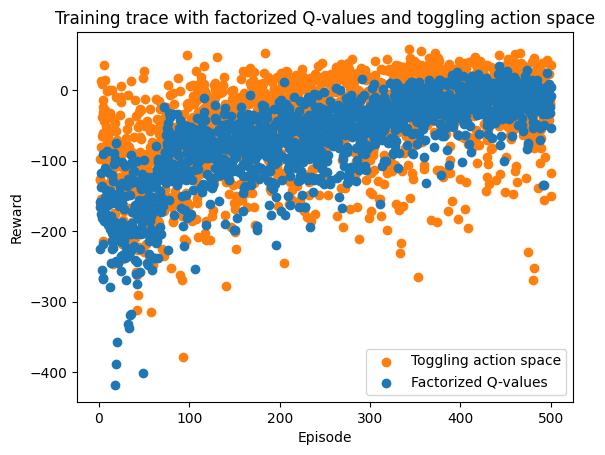

In [ ]:
x_train = np.linspace(1,500,500)

#plotting the results 
plt.scatter(x_train, training_trace_1_tog, color='tab:orange')
plt.scatter(x_train, training_trace_2_tog, color='tab:orange')
plt.scatter(x_train, training_trace_3_tog, color='tab:orange', label='Toggling action space')

plt.scatter(x_train, training_trace_1_fac, color='tab:blue')
plt.scatter(x_train, training_trace_2_fac, color='tab:blue')
plt.scatter(x_train, training_trace_3_fac,color='tab:blue', label='Factorized Q-values')

plt.title("Training trace with factorized Q-values and toggling action space")
plt.xlabel('Episode')
plt.ylabel('Reward')


plt.legend(loc='lower right')

plt.show()

In [ ]:
eval_trace_fac = eval_trace_1_fac+eval_trace_2_fac+eval_trace_3_fac
eval_trace_fac = eval_trace_fac/3
print(eval_trace_fac)

tensor([-148.4661,  -45.4020,  -36.8629,  -29.7606,  -20.5912,   -1.8488,
          10.2361,   15.1001,   19.1144,   21.7363])


In [ ]:
eval_trace_tog = eval_trace_1_tog+eval_trace_2_tog+eval_trace_3_tog
eval_trace_tog = eval_trace_tog/3
print(eval_trace_tog)

tensor([-136.2715,  -45.5968,  -11.8819,  -11.4469,  -17.7001,    7.4321,
           6.8547,   -2.2888,    1.7399,    7.4135])


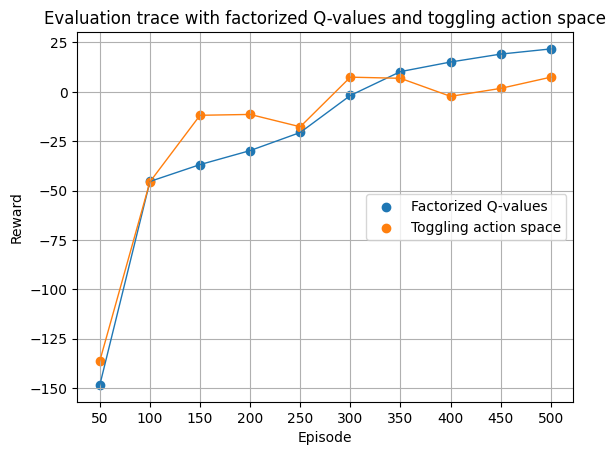

In [ ]:
##plotting code
x = np.linspace(50, 500, 10)

x_space = list(x)
plt.scatter(x, eval_trace_fac, label='Factorized Q-values')
plt.scatter(x, eval_trace_tog, label='Toggling action space')
plt.plot(x,eval_trace_fac, linewidth=1.0)
plt.plot(x,eval_trace_tog, linewidth=1.0)
plt.xticks(x_space)

plt.title("Evaluation trace with factorized Q-values and toggling action space")
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.legend(loc='center right')
plt.grid(True)

plt.show()

Let's now run 3 episodes using our best policy $\pi_{factor}^{*}$ and plot one of them:

In [ ]:
best_model_fac = best_model_2_fac
best_model_net = FactorizedQNetwork(n_observations, n_decisions, SEED).to(device)
best_model_net.load_state_dict(best_model_fac)
best_model_net.eval()

FactorizedQNetwork(
  (shared_layers): Sequential(
    (0): Linear(in_features=126, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (decision_layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [ ]:
finished = False
Rtot_eval = 0
seed_ep = 20
agentDQN = AgentDQN(env_DQN_fac)
obs_DQN, info = env_DQN_fac.reset(seed_ep)
agentDQN.reset()
log_j = []
      
      
while not finished:
  state = obs_DQN
  q_values = best_model_net(state.to(device).view(1, -1))
  action = torch.stack([torch.argmax(q_decision, dim=1) for q_decision in q_values], dim=1).view(4)
  obs_DQN, R, finished, info = env_DQN_fac.step(action)
  log_j.append(info)  # save the information dict for logging
  Rtot_eval = Rtot_eval+R

  if finished:
    print('total reward:', Rtot_eval)

total reward: tensor([[8.7343]])


In [ ]:
total_DQN = {p:np.array([getattr(l.total,p) for l in log_j]) for p in dyn.parameters}
cities_DQN = {c:{p:np.array([getattr(l.city[c],p) for l in log_j]) for p in dyn.parameters} for c in dyn.cities}
actions_DQN = {a:np.array([l.action[a] for l in log_j]) for a in log_j[0].action.keys()}

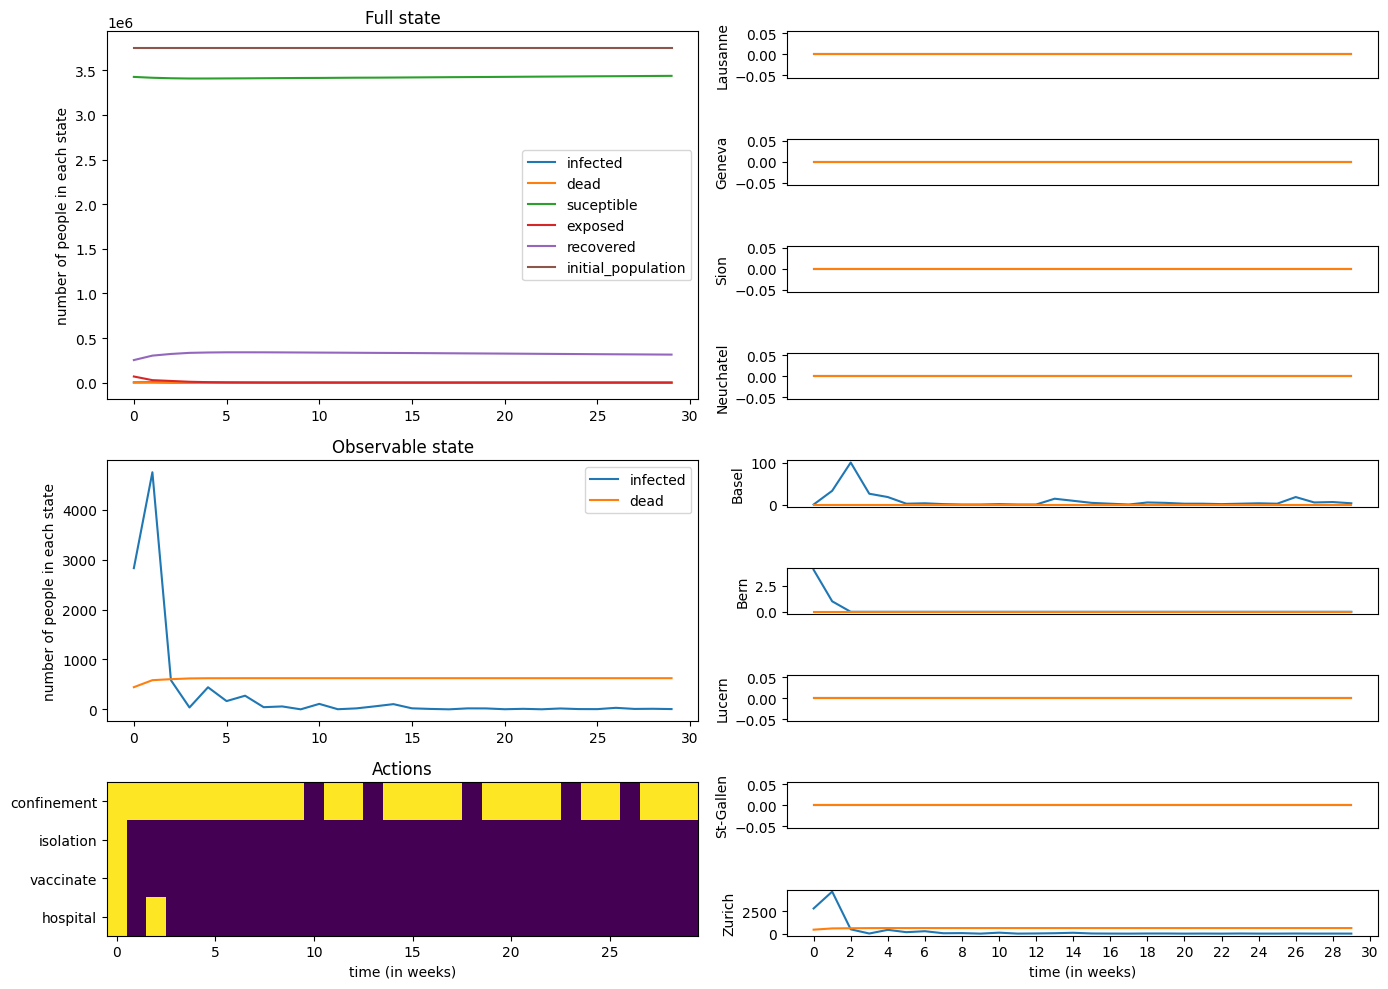

In [ ]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities_DQN.keys())}

[ax_leftstate.plot(y) for y in total_DQN.values()]
ax_leftstate.legend(total_DQN.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total_DQN[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions_DQN.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions_DQN.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities_DQN[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities_DQN[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zurich'].set_xlabel('time (in weeks)')
ax_right['Zurich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

### 4.2.a) multi-action factorized Q-values policy evaluation

In [ ]:
nb_episode = 50

#create empty lists that will contain the interested values 
nb_confined_days_per_ep = []
nb_vaccinate_days_per_ep = []
nb_isolation_days_per_ep = []
nb_hospital_days_per_ep = []
cumulative_reward_per_ep = []
nb_dead_per_ep = []


log_action = []

for i in range(nb_episode):
  """ Run the simulation """
  log = []
  finished = False
  obs_DQN, info = env_DQN_fac.reset(i+1)
  #agent_DQN.reset()
  #agent.epsilon = 0
  Rtot = 0

  while not finished:
     state = obs_DQN
     q_values = best_model_net(state.to(device).view(1, -1))
     action = torch.stack([torch.argmax(q_decision, dim=1) for q_decision in q_values], dim=1).view(4)
     obs_DQN, R, finished, info = env_DQN_fac.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         
         nb_dead_per_ep.append(log[len(log)-1].total.dead)
         cumulative_reward_per_ep.append(Rtot.item())
         confined_week = np.zeros(len(log), np.int64)
         vaccinate_week = np.zeros(len(log), np.int64)
         isolation_week = np.zeros(len(log), np.int64)
         hospital_week = np.zeros(len(log), np.int64)
         for i in range(len(log)):
           # print('nb week',i,'with the following action:', log[i].action)
           if log[i].action['confinement']==True:
             confined_week[i] = 1*7 #nb of confined days = nb of confined week * 7 
           if log[i].action['isolation']==True:
             isolation_week[i] = 1*7
           if log[i].action['vaccinate']==True:
             vaccinate_week[i] = 1*7
           if log[i].action['hospital']==True:
             hospital_week[i] = 1*7
         nb_confined_days_per_ep.append(confined_week.sum())
         nb_vaccinate_days_per_ep.append(vaccinate_week.sum())
         nb_isolation_days_per_ep.append(isolation_week.sum())
         nb_hospital_days_per_ep.append(hospital_week.sum())
         break

In [ ]:
""" convert list to array """
nb_confined_days_per_ep = np.asarray(nb_confined_days_per_ep)
nb_hospital_days_per_ep = np.asarray(nb_hospital_days_per_ep)
nb_vaccinate_days_per_ep = np.asarray(nb_vaccinate_days_per_ep)
nb_isolation_days_per_ep = np.asarray(nb_isolation_days_per_ep)
cumulative_reward_per_ep = np.asarray(cumulative_reward_per_ep)
nb_dead_per_ep = np.asarray(nb_dead_per_ep)

In [ ]:
print(np.min(nb_confined_days_per_ep), np.max(nb_confined_days_per_ep))
print(np.min(nb_hospital_days_per_ep), np.max(nb_hospital_days_per_ep))
print(np.min(nb_vaccinate_days_per_ep), np.max(nb_vaccinate_days_per_ep))
print(np.min(nb_isolation_days_per_ep), np.max(nb_isolation_days_per_ep))
print(np.min(cumulative_reward_per_ep), np.max(cumulative_reward_per_ep))
print(np.min(nb_dead_per_ep), np.max(nb_dead_per_ep))

140 210
0 35
0 14
0 21
6.838001251220703 51.31321334838867
4 1564


In [ ]:
print(np.mean(nb_confined_days_per_ep))
print(np.mean(nb_hospital_days_per_ep))
print(np.mean(nb_vaccinate_days_per_ep))
print(np.mean(nb_isolation_days_per_ep))
print(np.mean(cumulative_reward_per_ep))
print(np.mean(nb_dead_per_ep))

192.08
7.42
1.82
4.62
22.80305170059204
381.46


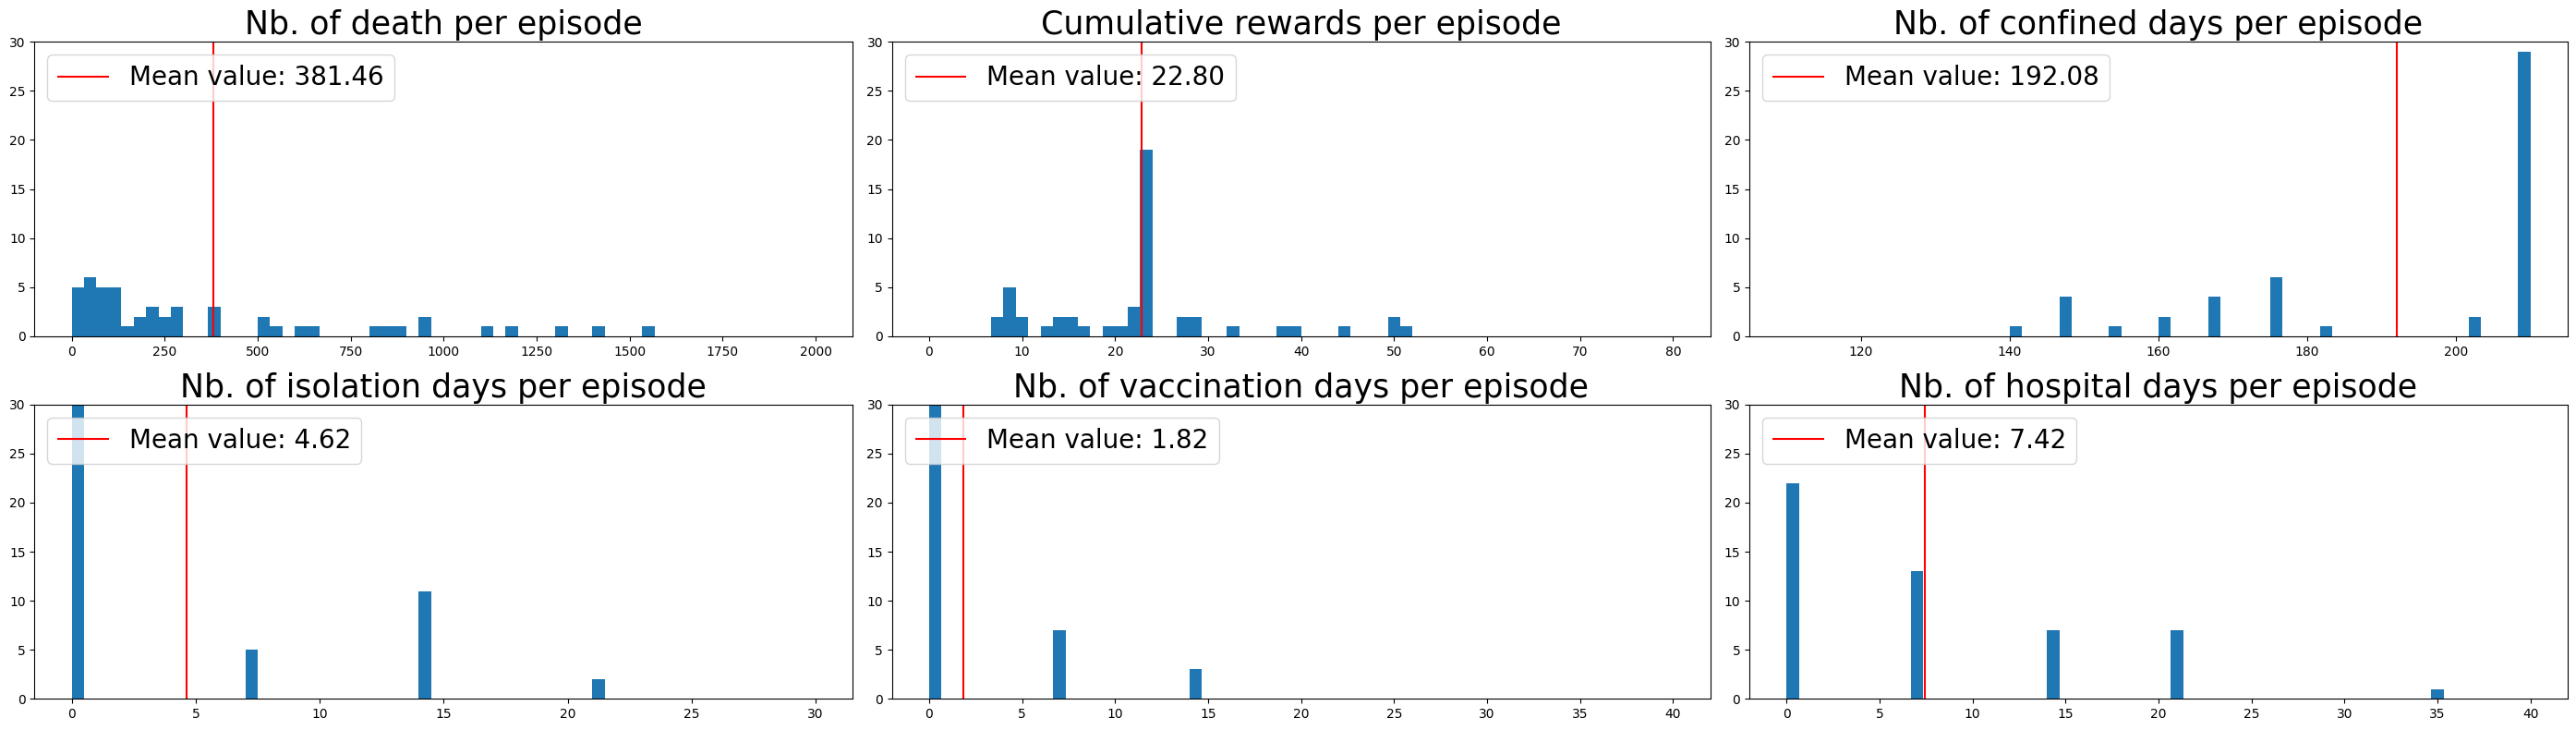

Average death number: 381.46
Average cumulative reward: 22.80305170059204
Average number of confined days: 192.08
Average number of isolation days:4.62
Average number of vaccinate days:1.82
Average number of hospital days:7.42


In [ ]:
""" Plotting the results """
fig, ax = plt.subplots(2,3,figsize=(28,8))
def hist_avg(ax, data,title, labelmean):
    ymax = 30
    if title == 'Nb. of death per episode':
        x_range = (0,2000)
    elif title == 'Cumulative rewards per episode': 
        x_range = (0,80)
    elif 'Nb. of confined days per episode' in title:
        x_range = (110,210)
    elif title == 'Nb. of isolation days per episode':
        x_range = (0, 30)
    elif title == 'Nb. of vaccination days per episode':
        x_range = (0, 40)
    elif title == 'Nb. of hospital days per episode':
        x_range = (0, 40)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title, fontsize=25)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red', label=labelmean)
    ax.hist(data,bins=60,range=x_range)
    ax.legend(loc='upper left', fontsize="20")
    
hist_avg(ax[0,0], nb_dead_per_ep,'Nb. of death per episode', 'Mean value: {:.2f}'.format(np.mean(nb_dead_per_ep)))
hist_avg(ax[0,1], cumulative_reward_per_ep,'Cumulative rewards per episode', 'Mean value: {:.2f}'.format(np.mean(cumulative_reward_per_ep)))
hist_avg(ax[0,2], nb_confined_days_per_ep,'Nb. of confined days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_confined_days_per_ep)))
hist_avg(ax[1,0], nb_isolation_days_per_ep,'Nb. of isolation days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_isolation_days_per_ep)))
hist_avg(ax[1,1], nb_vaccinate_days_per_ep,'Nb. of vaccination days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_vaccinate_days_per_ep)))
hist_avg(ax[1,2], nb_hospital_days_per_ep,'Nb. of hospital days per episode', 'Mean value: {:.2f}'.format(np.mean(nb_hospital_days_per_ep)))
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(nb_dead_per_ep)}')
print(f'Average cumulative reward: {np.mean(cumulative_reward_per_ep)}')
print(f'Average number of confined days: {np.mean(nb_confined_days_per_ep)}')
print(f'Average number of isolation days:{np.mean(nb_isolation_days_per_ep)}')
print(f'Average number of vaccinate days:{np.mean(nb_vaccinate_days_per_ep)}')
print(f'Average number of hospital days:{np.mean(nb_hospital_days_per_ep)}')

# 5) Wrapping Up

## 5.a) Comparing the training behaviors

See report

## 5.b) Comparing policies

Defining Constants and Vectors

In [ ]:
N_EPISODES = 50

CONFINED_DAYS = []
ISOLATION_DAYS = []
VACCINATION_DAYS = []
HOSPITAL_DAYS = []
DEATHS = []
CUM_REWARD = []

CONFINED_DAYS_AVG = []
ISOLATION_DAYS_AVG = []
VACCINATION_DAYS_AVG = []
HOSPITAL_DAYS_AVG = []
DEATHS_AVG = []
CUM_REWARD_AVG = []

### Professor Russo's policy

Professor Russo's policy was "trained" only once -> Model is the best model.

In [ ]:
agentR = RussoPolicyAgent(env_russo)

for i in range(N_EPISODES):
  """ Run the simulation """
  log = []
  finished = False
  count = 0
  obs_russo, info = env_russo.reset(i+1)
  agentR.reset()
  agentR.epsilon = 0 # Check
  Rtot = 0

  while not finished:
     action, count = agentR.act(obs_russo[0], count)
     #action is given to env_russo as a number : 0 or 1
     obs_russo, R, finished, info = env_russo.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         DEATHS.append(obs_russo[1])
         CUM_REWARD.append(Rtot.item())
         confined_week = np.zeros(len(log), np.int64)
         for i in range(len(log)):
           if log[i].action['confinement']==True:
             confined_week[i]=1*7 #nb of confined days = nb of confined week * 7 
         CONFINED_DAYS.append(confined_week.sum())
         break

# Russo does not consider isolation, vaccination, or hospitalization
ISOLATION_DAYS.extend([0]*N_EPISODES)
VACCINATION_DAYS.extend([0]*N_EPISODES)
HOSPITAL_DAYS.extend([0]*N_EPISODES)

Average of variables for Russo's policy

In [ ]:
CONFINED_DAYS_AVG.append(np.mean(CONFINED_DAYS))
ISOLATION_DAYS_AVG.append(np.mean(ISOLATION_DAYS))
VACCINATION_DAYS_AVG.append(np.mean(VACCINATION_DAYS))
HOSPITAL_DAYS_AVG.append(np.mean(HOSPITAL_DAYS))
DEATHS_AVG.append(np.mean(DEATHS))
CUM_REWARD_AVG.append(np.mean(CUM_REWARD))

### DQN's policy

First open the 3 files with decreasing exploration (better performance)

In [ ]:
open_file_1_eps = open("DQN_trace_1_eps.pkl", "rb")
output_1_eps = pickle.load(open_file_1_eps)
open_file_1_eps.close()

open_file_2_eps = open("DQN_trace_2_eps.pkl", "rb")
output_2_eps = pickle.load(open_file_2_eps)
open_file_2_eps.close()

open_file_3_eps = open("DQN_trace_3_eps.pkl", "rb")
output_3_eps = pickle.load(open_file_3_eps)
open_file_3_eps.close()

Find best model (best cumulative reward)

In [ ]:
# Find best model between the 3 trained (sum of reward)

cum_reward_eps = np.array([np.array(output_1_eps[0][-1]), np.array(output_2_eps[0][-1]), np.array(output_3_eps[0][-1])])

output_eps = [output_1_eps, output_2_eps, output_3_eps]

index_best_model_eps = np.argmax(cum_reward_eps)

output_eps = output_eps[index_best_model_eps]

best_model_eps = output_eps[3]

# Verification

print("Following line should be 0.0")

print(np.array(output_eps[0][-1]) - np.max([np.array(output_1_eps[0][-1]), np.array(output_2_eps[0][-1]), np.array(output_3_eps[0][-1])]))

Following line should be 0.0
0.0


Evaluate variables of interest (here again only confinement is considered)

In [ ]:
N_OBS = 7*9*2 # (days in a week) * (number of cities) * (infected or dead)
N_ACT = 2 # confine or not

SEED = 2

CONFINED_DAYS = []
ISOLATION_DAYS = []
VACCINATION_DAYS = []
HOSPITAL_DAYS = []
DEATHS = []
CUM_REWARD = []

LIST_Q_VALUES_DQN = []
LIST_ACTIONS_DQN = []

In [ ]:
#upload best model parameters to the new NN
best_model_eps_net = DQN(N_OBS, N_ACT, SEED).to(device)
best_model_eps_net.load_state_dict(best_model_eps)
best_model_eps_net.eval()

DQN(
  (layer1): Linear(in_features=126, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
N_EPISODES = 50 

agent_DQN = AgentDQN(env_DQN)

for i in range(N_EPISODES):
  """ Run the simulation """
  log = []
  finished = False
  count = 0
  obs_DQN, info = env_DQN.reset(i+1)
  agent_DQN.reset()
  Rtot = 0

  while not finished:
     state = obs_DQN
     action = best_model_eps_net(state.to(device).reshape(1,-1)).max(1)[1].view(1,1)
     #action is given to env_russo as a number : 0 or 1
     LIST_ACTIONS_DQN.append(action)
     q_values_dqn = best_model_eps_net(state.reshape(1,-1).to(device))
     LIST_Q_VALUES_DQN.append(q_values_dqn)
     obs_DQN, R, finished, info = env_DQN.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         DEATHS.append(log[len(log)-1].total.dead)
         CUM_REWARD.append(Rtot.item())
         confined_week = np.zeros(len(log), np.int64)
         for i in range(len(log)):
           if log[i].action['confinement']==True:
             confined_week[i]=1*7 #nb of confined days = nb of confined week * 7 
         CONFINED_DAYS.append(confined_week.sum())
         break

# DQN does not consider isolation, vaccination, or hospitalization
ISOLATION_DAYS.extend([0]*N_EPISODES)
VACCINATION_DAYS.extend([0]*N_EPISODES)
HOSPITAL_DAYS.extend([0]*N_EPISODES)

Average of variables of interest for DQN's policy :

In [ ]:
CONFINED_DAYS_AVG.append(np.mean(CONFINED_DAYS))
ISOLATION_DAYS_AVG.append(np.mean(ISOLATION_DAYS))
VACCINATION_DAYS_AVG.append(np.mean(VACCINATION_DAYS))
HOSPITAL_DAYS_AVG.append(np.mean(HOSPITAL_DAYS))
DEATHS_AVG.append(np.mean(DEATHS))
CUM_REWARD_AVG.append(np.mean(CUM_REWARD))

### Toggle Policy


First open the 3 .pkl files

In [ ]:
open_file_1_toggle = open("DQN_trace_1_tog.pkl", "rb")
output_1_toggle = pickle.load(open_file_1_toggle)
open_file_1_toggle.close()

open_file_2_toggle = open("DQN_trace_2_tog.pkl", "rb")
output_2_toggle = pickle.load(open_file_2_toggle)
open_file_2_toggle.close()

open_file_3_toggle = open("DQN_trace_3_tog.pkl", "rb")
output_3_toggle = pickle.load(open_file_3_toggle)
open_file_3_toggle.close()

Find best model (best cumulative reward)

In [ ]:
# Find best model between the 3 trained (sum of reward)

cum_reward_toggle = np.array([np.array(output_1_toggle[0][-1]), np.array(output_2_toggle[0][-1]), np.array(output_3_toggle[0][-1])])

output_toggle = [output_1_toggle, output_2_toggle, output_3_toggle]

index_best_model_toggle = np.argmax(cum_reward_toggle)

output_toggle = output_toggle[index_best_model_toggle]

best_model_toggle = output_toggle[3]

# Verification

print("Following line should be 0.0")

print(np.array(output_toggle[0][-1]) - np.max([np.array(output_1_toggle[0][-1]), np.array(output_2_toggle[0][-1]), np.array(output_3_toggle[0][-1])]))

Following line should be 0.0
0.0


Evaluate model

In [ ]:
N_OBS = 7*9*2+4 # (days in a week) * (number of cities) * (infected or dead) + (state of actions)
N_ACT = 5

SEED = 2

CONFINED_DAYS = []
ISOLATION_DAYS = []
VACCINATION_DAYS = []
HOSPITAL_DAYS = []
DEATHS = []
CUM_REWARD = []

In [ ]:
#upload best model parameters to the new NN
best_model_toggle_net = DQN(N_OBS, N_ACT, SEED).to(device)
best_model_toggle_net.load_state_dict(best_model_toggle)
best_model_toggle_net.eval()

DQN(
  (layer1): Linear(in_features=130, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=5, bias=True)
)

In [ ]:
N_EPISODES = 50

agent_DQN = AgentDQN(env_DQN_toggle)

dummy = []

for i in range(N_EPISODES):
  """ Run the simulation """
  log = []
  finished = False
  count = 0
  obs_DQN, info = env_DQN_toggle.reset(i+1)
  agent_DQN.reset()
  Rtot = 0

  while not finished:
     state = obs_DQN
     action = best_model_toggle_net(state.to(device).reshape(1,-1)).max(1)[1].view(1,1)
     #action is given to env_russo as a number : 0 or 1
     obs_DQN, R, finished, info = env_DQN_toggle.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         DEATHS.append(log[len(log)-1].total.dead)
         CUM_REWARD.append(Rtot.item())
         cum_action = np.zeros(4, np.int64)
         for i in range(len(log)):
          #print(log[i].action)
          dummy.append(i)
          cum_action = cum_action + np.array(list(log[i].action.values()))*7
         CONFINED_DAYS.append(cum_action[0])
         ISOLATION_DAYS.append(cum_action[1])
         VACCINATION_DAYS.append(cum_action[2])
         HOSPITAL_DAYS.append(cum_action[3])
         break

In [ ]:
CONFINED_DAYS_AVG.append(np.mean(CONFINED_DAYS))
ISOLATION_DAYS_AVG.append(np.mean(ISOLATION_DAYS))
VACCINATION_DAYS_AVG.append(np.mean(VACCINATION_DAYS))
HOSPITAL_DAYS_AVG.append(np.mean(HOSPITAL_DAYS))
DEATHS_AVG.append(np.mean(DEATHS))
CUM_REWARD_AVG.append(np.mean(CUM_REWARD))

### Factor Policy

First open the 3 .pkl files

In [ ]:
open_file_1_fac = open("DQN_trace_1_fac.pkl", "rb")
output_1_fac = pickle.load(open_file_1_fac)
open_file_1_fac.close()

open_file_2_fac = open("DQN_trace_2_fac.pkl", "rb")
output_2_fac = pickle.load(open_file_2_fac)
open_file_2_fac.close()

open_file_3_fac = open("DQN_trace_3_fac.pkl", "rb")
output_3_fac = pickle.load(open_file_3_fac)
open_file_3_fac.close()

Find best model (best cumulative reward)

In [ ]:
# Find best model between the 3 trained (sum of reward)

cum_reward_fac = np.array([np.array(output_1_fac[0][-1]), np.array(output_2_fac[0][-1]), np.array(output_3_fac[0][-1])])

output_fac = [output_1_fac, output_2_fac, output_3_fac]

index_best_model_fac = np.argmax(cum_reward_fac)

output_fac = output_fac[index_best_model_fac]

best_model_fac = output_fac[3]

# Verification

print("Following line should be 0.0")

print(np.array(output_fac[0][-1]) - np.max([np.array(output_1_fac[0][-1]), np.array(output_2_fac[0][-1]), np.array(output_3_fac[0][-1])]))

Following line should be 0.0
0.0


Evaluate model

In [ ]:
N_OBS = 7*9*2 # (days in a week) * (number of cities) * (infected or dead)
N_ACT = 4

SEED = 2

CONFINED_DAYS = []
ISOLATION_DAYS = []
VACCINATION_DAYS = []
HOSPITAL_DAYS = []
DEATHS = []
CUM_REWARD = []

LIST_Q_VALUES_FAC = []
LIST_ACTIONS_FAC = []

In [ ]:
#upload best model parameters to the new NN
best_model_fac_net = FactorizedQNetwork(N_OBS, N_ACT, SEED).to(device)
best_model_fac_net.load_state_dict(best_model_fac)
best_model_fac_net.eval()

FactorizedQNetwork(
  (shared_layers): Sequential(
    (0): Linear(in_features=126, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (decision_layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [ ]:
agent_DQN = AgentDQN(env_DQN_fac)

N_EPISODES = 50

dummy = []

for i in range(N_EPISODES):
  """ Run the simulation """
  log = []
  finished = False
  obs_DQN, info = env_DQN_fac.reset(i+1)
  agent_DQN.reset()
  Rtot = 0

  while not finished:
     state = obs_DQN
     q_values = best_model_fac_net(state.to(device).view(1, -1))
     action = torch.stack([torch.argmax(q_decision, dim=1) for q_decision in q_values], dim=1).view(4)
     LIST_ACTIONS_FAC.append(action)
     q_values_fac = best_model_fac_net(state.reshape(1,-1).to(device))
     LIST_Q_VALUES_FAC.append(q_values_fac)
     obs_DQN, R, finished, info = env_DQN_fac.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         DEATHS.append(log[len(log)-1].total.dead)
         CUM_REWARD.append(Rtot.item())
         cum_action = np.zeros(4, np.int64)

         for i in range(len(log)):
          #print(log[i].action)
          dummy.append(i)
          cum_action = cum_action + np.array(list(log[i].action.values()))*7

         CONFINED_DAYS.append(cum_action[0])
         ISOLATION_DAYS.append(cum_action[1])
         VACCINATION_DAYS.append(cum_action[2])
         HOSPITAL_DAYS.append(cum_action[3])
         break

In [ ]:
CONFINED_DAYS_AVG.append(np.mean(CONFINED_DAYS))
ISOLATION_DAYS_AVG.append(np.mean(ISOLATION_DAYS))
VACCINATION_DAYS_AVG.append(np.mean(VACCINATION_DAYS))
HOSPITAL_DAYS_AVG.append(np.mean(HOSPITAL_DAYS))
DEATHS_AVG.append(np.mean(DEATHS))
CUM_REWARD_AVG.append(np.mean(CUM_REWARD))

### Comparison

Let's now compare policies

In [ ]:
DEATHS_AVG_ARRAY = np.array(DEATHS_AVG)
CUM_REWARD_AVG_ARRAY = np.array(CUM_REWARD_AVG)
CONFINED_DAYS_AVG_ARRAY = np.array(CONFINED_DAYS_AVG)
ISOLATION_DAYS_AVG_ARRAY = np.array(ISOLATION_DAYS_AVG)
VACCINATION_DAYS_AVG_ARRAY = np.array(VACCINATION_DAYS_AVG)
HOSPITAL_DAYS_AVG_ARRAY = np.array(HOSPITAL_DAYS_AVG)

print(np.around(DEATHS_AVG_ARRAY,2))
print(np.around(CUM_REWARD_AVG_ARRAY,2))
print(np.around(CONFINED_DAYS_AVG_ARRAY,2))
print(np.around(ISOLATION_DAYS_AVG_ARRAY,2))
print(np.around(VACCINATION_DAYS_AVG_ARRAY,2))
print(np.around(HOSPITAL_DAYS_AVG_ARRAY,2))

[59053.52  4452.52 12204.68   381.46]
[-70.62  44.24  15.49  22.8 ]
[ 98.98 153.44 154.56 192.08]
[0.   0.   4.76 4.62]
[0.   0.   0.   1.82]
[ 0.    0.   46.48  7.42]


In [ ]:
from prettytable import PrettyTable
my_table = PrettyTable()

policy_names = ["Russo", "DQN", "Toggle", "Factorized"]

my_table.field_names = ["Policy", "Deaths", "Cumulative Reward", "Confined Days", "Isolated Days", "Days of Vaccination", "Additional Hospital Days"]

for i in range(4):
  my_table.add_row([policy_names[i], round(DEATHS_AVG[i],2), round(CUM_REWARD_AVG[i],2), round(CONFINED_DAYS_AVG[i],2), round(ISOLATION_DAYS_AVG[i],2), round(VACCINATION_DAYS_AVG[i],2), round(HOSPITAL_DAYS_AVG[i],2)])

print(my_table)

+------------+----------+-------------------+---------------+---------------+---------------------+--------------------------+
|   Policy   |  Deaths  | Cumulative Reward | Confined Days | Isolated Days | Days of Vaccination | Additional Hospital Days |
+------------+----------+-------------------+---------------+---------------+---------------------+--------------------------+
|   Russo    | 59053.52 |       -70.62      |     98.98     |      0.0      |         0.0         |           0.0            |
|    DQN     | 4452.52  |       44.24       |     153.44    |      0.0      |         0.0         |           0.0            |
|   Toggle   | 12204.68 |       15.49       |     154.56    |      4.76     |         0.0         |          46.48           |
| Factorized |  381.46  |        22.8       |     192.08    |      4.62     |         1.82        |           7.42           |
+------------+----------+-------------------+---------------+---------------+---------------------+------------

### 5.c) Interpretability

Let's start with DQN.

Best model was extracted above and Q-Values were extracted. We can, therefore, directly use them.

In [ ]:
LIST_ACTIONS_DQN = []
q_values_dqn = []
LIST_Q_VALUES_DQN = []

In [ ]:
N_EPISODES = 1

agent_DQN = AgentDQN(env_DQN)

for i in range(N_EPISODES):
  """ Run the simulation """
  log = []
  finished = False
  count = 0
  obs_DQN, info = env_DQN.reset(i+1)
  agent_DQN.reset()
  Rtot = 0

  while not finished:
     state = obs_DQN
     action = best_model_eps_net(state.to(device).reshape(1,-1)).max(1)[1].view(1,1)
     #action is given to env_russo as a number : 0 or 1
     LIST_ACTIONS_DQN.append(action)
     q_values_dqn = best_model_eps_net(state.reshape(1,-1).to(device))
     LIST_Q_VALUES_DQN.append(q_values_dqn)
     obs_DQN, R, finished, info = env_DQN.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         DEATHS.append(log[len(log)-1].total.dead)
         CUM_REWARD.append(Rtot.item())
         confined_week = np.zeros(len(log), np.int64)
         for i in range(len(log)):
           if log[i].action['confinement']==True:
             confined_week[i]=1*7 #nb of confined days = nb of confined week * 7 
         CONFINED_DAYS.append(confined_week.sum())
         break

# DQN does not consider isolation, vaccination, or hospitalization
ISOLATION_DAYS.extend([0]*N_EPISODES)
VACCINATION_DAYS.extend([0]*N_EPISODES)
HOSPITAL_DAYS.extend([0]*N_EPISODES)

In [ ]:
# q_values_dqn = torch.stack(LIST_Q_VALUES_DQN).view(tt.size(0), -1)

q_values_dqn = torch.stack(LIST_Q_VALUES_DQN).view(len(LIST_Q_VALUES_DQN), -1)

# print(q_values_dqn)

tensor([[-44.8458,   4.0800],
        [  7.8193,  14.0760],
        [ 13.2051,  16.0011],
        [ 16.2079,  17.0821],
        [ 17.8626,  18.1451],
        [ 18.0936,  18.2912],
        [ 18.9008,  18.8893],
        [ 14.7020,  13.1837],
        [ -7.5042,   4.4378],
        [-11.3388,  12.8974],
        [ 13.3282,  17.4371],
        [ 17.1884,  19.1627],
        [ 19.3323,  19.9340],
        [ 19.9112,  20.2280],
        [ 21.1819,  20.9919],
        [ 17.7313,  15.3897],
        [ 10.3390,   8.2982],
        [  6.4966,   6.7217],
        [  7.6926,  14.4163],
        [ 13.2487,  16.7596],
        [ 13.1312,  17.3409],
        [ 16.3666,  17.9659],
        [ 19.5102,  19.6488],
        [ 20.8280,  20.5631],
        [ 13.4357,   9.8878],
        [  9.2869,   9.0408],
        [  0.3650,   3.8095],
        [  6.9041,  14.6664],
        [ 12.9798,  15.8777],
        [ 14.0063,  15.9869]], device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn 
import pandas as pd 

In [ ]:
N_Q_VALUES = 2
TIME_LENGTH = 30 

classes = ('Confinement : FALSE', 'Confinement : TRUE')

q_val_array_dqn = q_values_dqn.cpu().detach().numpy()


Text(0.5, 1.0, 'Heat map for $\\pi_{DQN}^{*}$ policy')

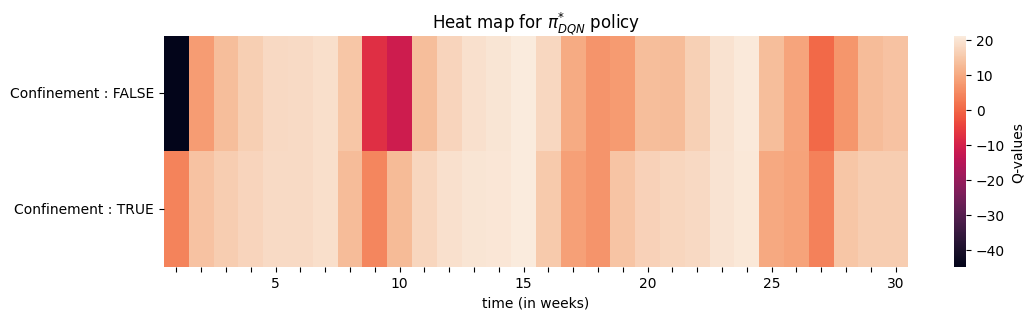

In [ ]:
plt.figure(figsize = (12, 3))

x_axis_labels = []

for i in range(30):
    if not (i+1)%5:
        x_axis_labels.append(i+1)
    else:
        x_axis_labels.append(None)

y_axis_labels = ['Confinement : FALSE', 'Confinement : TRUE']

heat_map = sn.heatmap(q_val_array_dqn.T, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar_kws={'label': 'Q-values'})

plt.xlabel('time (in weeks)')
plt.title('Heat map for $\pi_{DQN}^{*}$ policy')

Factorized Policy

In [ ]:
agent_DQN = AgentDQN(env_DQN_fac)

LIST_ACTIONS_FAC = []
q_values_fac = []
LIST_Q_VALUES_FAC_CONF = []
LIST_Q_VALUES_FAC_ISOL = []
LIST_Q_VALUES_FAC_HOSP = []
LIST_Q_VALUES_FAC_VACC = []

N_EPISODES = 1

# cum_action = np.zeros(4, np.int64)

dummy = []

for i in range(N_EPISODES):
  """ Run the simulation """
  log = []
  finished = False
  obs_DQN, info = env_DQN_fac.reset(i+1)
  agent_DQN.reset()
  Rtot = 0

  while not finished:
     state = obs_DQN
     q_values = best_model_fac_net(state.to(device).view(1, -1))
     action = torch.stack([torch.argmax(q_decision, dim=1) for q_decision in q_values], dim=1).view(4)
     LIST_ACTIONS_FAC.append(action)
     q_values_fac = best_model_fac_net(state.reshape(1,-1).to(device))
     #LIST_Q_VALUES_FAC.append(q_values_fac)
     LIST_Q_VALUES_FAC_CONF.append(q_values_fac[0][0].cpu().detach().numpy())
     LIST_Q_VALUES_FAC_ISOL.append(q_values_fac[1][0].cpu().detach().numpy())
     LIST_Q_VALUES_FAC_HOSP.append(q_values_fac[2][0].cpu().detach().numpy())
     LIST_Q_VALUES_FAC_VACC.append(q_values_fac[3][0].cpu().detach().numpy())
     obs_DQN, R, finished, info = env_DQN_fac.step(action)
     log.append(info) # save the information dict for logging
     Rtot = Rtot + R
     if finished:
         DEATHS.append(log[len(log)-1].total.dead)
         CUM_REWARD.append(Rtot.item())
         cum_action = np.zeros(4, np.int64)

         for i in range(len(log)):
          #print(log[i].action)
          dummy.append(i)
          cum_action = cum_action + np.array(list(log[i].action.values()))*7

         CONFINED_DAYS.append(cum_action[0])
         ISOLATION_DAYS.append(cum_action[1])
         VACCINATION_DAYS.append(cum_action[2])
         HOSPITAL_DAYS.append(cum_action[3])
         break

In [ ]:
Q_VALUES_FAC_HEAT = []

for i in range(len(LIST_Q_VALUES_FAC_CONF)):
  Q_VALUES_FAC_HEAT.append([*LIST_Q_VALUES_FAC_CONF[i], *LIST_Q_VALUES_FAC_ISOL[i], *LIST_Q_VALUES_FAC_HOSP[i], *LIST_Q_VALUES_FAC_VACC[i]])


(30, 8)


Text(0.5, 1.0, 'Heat map for $\\pi_{fac}^{*}$ policy')

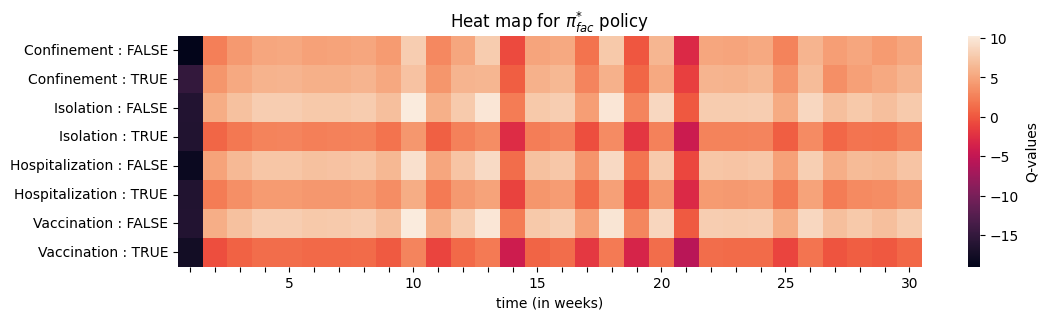

In [ ]:
Q_VALUES_FAC_HEAT = np.array(Q_VALUES_FAC_HEAT)

print(Q_VALUES_FAC_HEAT.shape)

plt.figure(figsize = (12, 3))

x_axis_labels = []

for i in range(30):
    if not (i+1)%5:
        x_axis_labels.append(i+1)
    else:
        x_axis_labels.append(None)

y_axis_labels = ['Confinement : FALSE','Confinement : TRUE','Isolation : FALSE','Isolation : TRUE','Hospitalization : FALSE','Hospitalization : TRUE','Vaccination : FALSE','Vaccination : TRUE']

heat_map = sn.heatmap(Q_VALUES_FAC_HEAT.T, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cbar_kws={'label': 'Q-values'})

plt.xlabel('time (in weeks)')
plt.title('Heat map for $\pi_{fac}^{*}$ policy')

In [ ]:
# Check

#print(LIST_Q_VALUES_FAC_CONF)
#print(LIST_Q_VALUES_FAC_ISOL)
#print(LIST_Q_VALUES_FAC_HOSP)
#print(LIST_Q_VALUES_FAC_VACC)

[array([-19.01786 , -15.035148], dtype=float32), array([2.4464426, 3.9189682], dtype=float32), array([4.1136904, 5.2557983], dtype=float32), array([5.069977, 5.973322], dtype=float32), array([5.159215 , 6.0868797], dtype=float32), array([4.7768927, 5.780883 ], dtype=float32), array([4.817805 , 5.8129854], dtype=float32), array([5.12498  , 6.1384573], dtype=float32), array([4.2551804, 5.1984797], dtype=float32), array([7.992389 , 7.1997013], dtype=float32), array([3.0484917, 3.9804442], dtype=float32), array([5.051906 , 6.1296444], dtype=float32), array([7.7802777, 6.270438 ], dtype=float32), array([-0.7535395 ,  0.43984175], dtype=float32), array([4.921789 , 5.8684807], dtype=float32), array([5.3032904, 6.300152 ], dtype=float32), array([1.6709049, 2.810461 ], dtype=float32), array([7.6496778, 5.901553 ], dtype=float32), array([-0.04278439,  0.8510692 ], dtype=float32), array([6.2516503, 5.3257475], dtype=float32), array([-2.9405017, -1.4259889], dtype=float32), array([5.1108465, 6.061